# House sales predictions


## Table of contents
1. [Introduction](#introduction)
2. [Short summary](#paragraph1)
3. [Imports](#paragraph2)
4. [Reading the data](#paragraph3)
5. [Data exploration](#paragraph4)
    1. [Missing values](#subparagraph1)
    2. [Feature descriptions](#subparagraph19)
    3. [Finding featuer relations](#subparagraph2)
    4. [Plotting some features](#subparagraph3)
6. [Cleaning the data](#paragraph5)
    1. [Removing outliers](#subparagraph4)
    2. [Feature engineering](#subparagraph5)
    3. [Fixing skew](#subparagraph6)
7. [Predictions](#paragraph6)
    1. [Linear Regression](#subparagraph7)
    2. [Kernel Ridge Regularization](#subparagraph8)
    3. [Bayesian Rigde Regression](#subparagraph9)
    4. [Random Rorrest Regression](#subparagraph10)
    5. [Support Vector Regression](#subparagraph11)
    6. [Gradient Boosting](#subparagraph12)
    7. [XGBoost](#subparagraph13)
    8. [LightGBM](#subparagraph14)
    9. [Stacking Regressor](#subparagraph15)
8. [Capturing large errors](#paragraph7)
9. [Multiple models](#paragraph8)
    1. [Finalcial crisis model](#subparagraph16)
    2. [Non crisis model](#subparagraph17)
    3. [Merging the models](#subparagraph18)
10. [Making the submission](#paragraph9)
11. [References](#paragraph10)

## Introduction  <a name="introduction"></a>

https://services.unimelb.edu.au/__data/assets/pdf_file/0009/471294/Using_tenses_in_scientific_writing_Update_051112.pdf

#Should be in present tense

In this lab the objective is to predict the price of a house based on its features. We have training data containing 79 features per house, excluding the Id and sale price. We also have some test data containg those same features, but not the sale price. To predict the values of the test houses we build statistical models. The models use the supplied features and turns them into a prediction of the sale price. Before we start the prediction, we will first explore the data for features correlating to the price, and abnormalities that may interfere with our predictions. We will also engineer our own features to increase the accuracy of our model. Finaly we choose the model for our prediction. The result of the prediction is to be submitted in a challenge where the rank is calculated by comparing the root mean square error for all the submitted predictions.

## Short summary  <a name="paragraph1"></a>

#Should be in passed tense. Summary of the whole report. Usually written after the scientific work is complete.

First will look at the missing values for the test and training data, to see if datasets may be biased in any way. Then we are going to look at the numerical and categorical features for both datasets. This is to see if the distribution of the values in the test and training data are very different. Next its time to plot some selected features and look at their relationship with other features, and the sales price.

After the data exploration is finished, we remove potential outliers that may bias our predictions. Feature engineering is a very important part of the machine learning process, so after the ourliers have been removed we will add some custom features, that may capture more relations in the dataset. Many of our numericals features are skewed. This may bias our predictions, so this will be fixed by Box-Cox tranform features that have a skew above a threshold.

Next its time to start training some models and making some predictions. We will use several different models and look at how they perform perform compared to each other. Then we will select the best models to be used in a stacking regressor, and see how this improves our predictions. Next we will look at large errors in our predictions and try to figure our why they are so large. Our dataset contains sales from the year 2007, 2008, 2009 and 2010, so by looking at the large errors in predictions we saw that most of them were sold in 2008. When we think about it, 2008 was a bad year for the entire economy. The financial crisis was at its worst, and compared to the other years its a totaly different market. So we split out model into two. One for houses sold in 2008 and one for all other. Lastly it is time to make the final submission.

## Imports  <a name="paragraph2"></a>

In [1]:
import warnings
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import lightgbm as lgb
import xgboost as xgb
import matplotlib.ticker as ticker
import optunity as opt
import optunity.metrics
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression , Ridge , Lasso , BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_log_error
from sklearn import cross_validation
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import load_digits
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import ShuffleSplit
from sklearn.grid_search import GridSearchCV
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from sklearn.svm import SVR


#sns.set_style('white')
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
base = "./challenge_data/"


C:\Users\Christian\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Christian\Anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)
C:\Users\Christian\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  Deprecati

## Reading the data  <a name="paragraph3"></a>

In [2]:
# loading the data
houseDataDF = pd.read_csv(base + "train.csv")
idColl = houseDataDF.Id
houseDataDF = houseDataDF.drop(["Id"],axis=1)
houseDataDF.index = idColl
trainSetLength = len(houseDataDF.values)
print("Training data shape:\t",houseDataDF.shape)

testDF = pd.read_csv(base + "test.csv")
testIdColl = testDF.Id
testDF = testDF.drop(["Id"],axis=1)
testDF.index = testIdColl
print("Test data shape:\t",testDF.shape)

Training data shape:	 (1200, 80)
Test data shape:	 (260, 79)


# Data Exploration  <a name="paragraph4"></a>

## Missing values  <a name="subparagraph1"></a>

Lets first see how many of the values in data than are empty, None or NAN.

Text(0.5,1,'Percent missing data by feature (training data)')

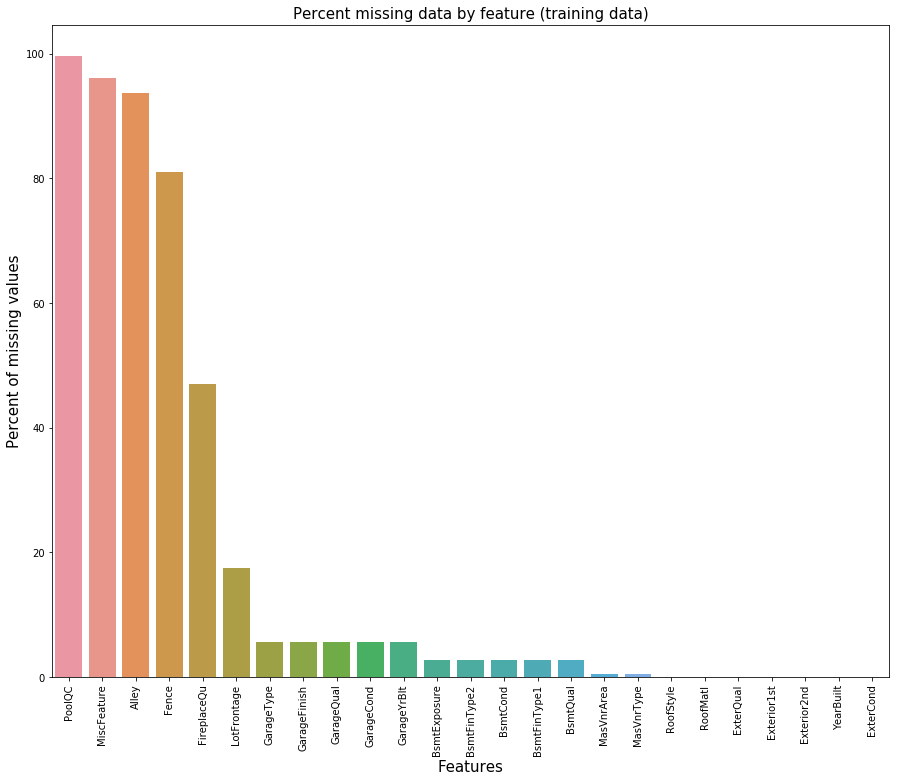

In [3]:
nulls = pd.DataFrame(houseDataDF.isnull().sum().sort_values(ascending=False)[:25])
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'

f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=nulls.index.values, y=nulls.values.ravel() * 100 /len(houseDataDF.values))
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature (training data)', fontsize=15)

The plot above shows that up to 80% the the data points are missing, for some features in the training data. Let us see if the same applies for the test data.

Text(0.5,1,'Percent missing data by feature (test data)')

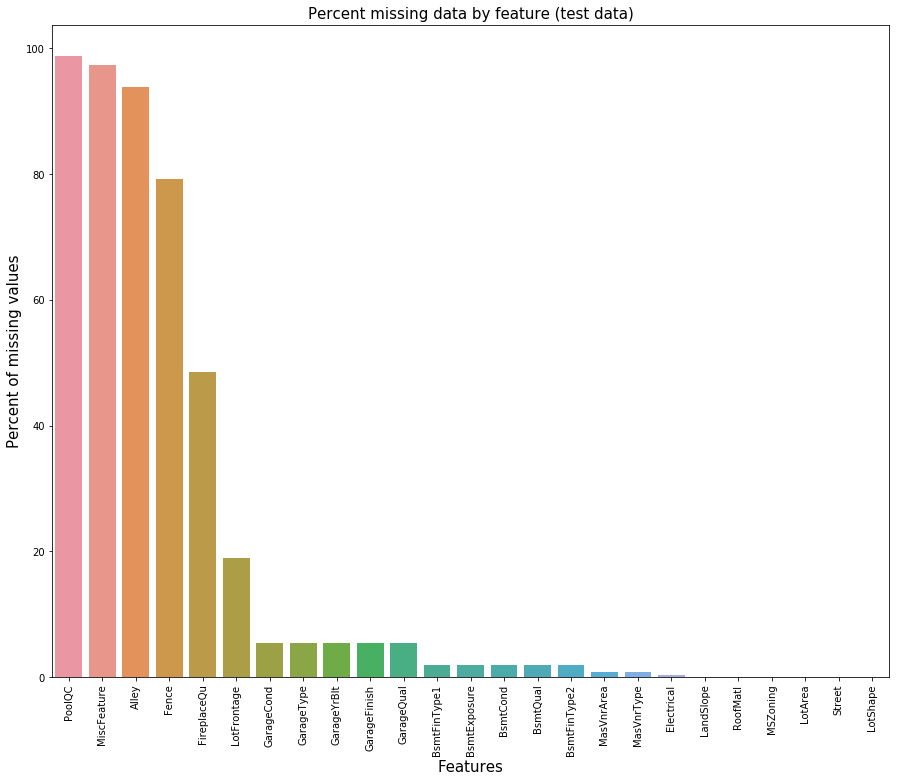

In [4]:
nulls = pd.DataFrame(testDF.isnull().sum().sort_values(ascending=False)[:25])
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'

f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=nulls.index.values, y=nulls.values.ravel() * 100 / len(testDF.values))
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature (test data)', fontsize=15)

We observe that the percentage of missing values are similar for test data as the training data. This is good news, as our predictions are not going to be biased by missing values.

We will fill in missing values with default ones.

In [5]:
houseDataDF["PoolQC"] = houseDataDF["PoolQC"].fillna("None")
houseDataDF["MiscFeature"] = houseDataDF["MiscFeature"].fillna("None")
houseDataDF["Alley"] = houseDataDF["Alley"].fillna("None")
houseDataDF["Fence"] = houseDataDF["Fence"].fillna("None")
houseDataDF["FireplaceQu"] = houseDataDF["FireplaceQu"].fillna("None")
houseDataDF["Functional"] = houseDataDF["Functional"].fillna("Typ")
houseDataDF["MasVnrType"] = houseDataDF["MasVnrType"].fillna("None")
houseDataDF['MSSubClass'] = houseDataDF['MSSubClass'].fillna("None")
houseDataDF["MasVnrArea"] = houseDataDF["MasVnrArea"].fillna(0)

#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
houseDataDF["LotFrontage"] = houseDataDF.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    houseDataDF[col] = houseDataDF[col].fillna('None')
    
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    houseDataDF[col] = houseDataDF[col].fillna(0)
    
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    houseDataDF[col] = houseDataDF[col].fillna(0)
    
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    houseDataDF[col] = houseDataDF[col].fillna('None')

# fill in missing values with the most usual ones.
houseDataDF['MSZoning'] = houseDataDF['MSZoning'].fillna(houseDataDF['MSZoning'].mode()[0])
houseDataDF['Electrical'] = houseDataDF['Electrical'].fillna(houseDataDF['Electrical'].mode()[0])
houseDataDF['KitchenQual'] = houseDataDF['KitchenQual'].fillna(houseDataDF['KitchenQual'].mode()[0])
houseDataDF['Exterior1st'] = houseDataDF['Exterior1st'].fillna(houseDataDF['Exterior1st'].mode()[0])
houseDataDF['Exterior2nd'] = houseDataDF['Exterior2nd'].fillna(houseDataDF['Exterior2nd'].mode()[0])
houseDataDF['SaleType'] = houseDataDF['SaleType'].fillna(houseDataDF['SaleType'].mode()[0])


## Feature descriptions  <a name="subparagraph19"></a>

Our data consists of both numerical and categorical features. For making predictions we must know the distributions of the values. First we look at the numerical features from the training data.

In [6]:
numericals = houseDataDF.select_dtypes(include=[np.number])
numericals.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.00000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,57.075000,70.197083,10559.411667,6.105000,5.568333,1971.350833,1984.987500,103.442500,444.886667,45.260000,564.553333,1054.700000,1157.430833,344.993333,6.553333,1508.97750,0.421667,0.061667,1.560833,0.382500,2.857500,1.045000,6.494167,0.614167,1867.910000,1.763333,472.604167,95.136667,46.016667,22.178333,3.653333,14.980833,1.909167,40.453333,6.311667,2007.810833,181414.628333
std,42.682012,21.916032,10619.135549,1.383439,1.120138,30.048408,20.527221,183.222075,439.987844,158.931453,440.388327,419.996306,375.238607,437.038023,52.077992,517.38033,0.520342,0.247484,0.552165,0.499735,0.819199,0.219123,1.614664,0.642113,455.061206,0.743494,212.722444,124.034129,65.677629,61.507323,29.991099,54.768057,33.148327,482.323444,2.673104,1.319027,81070.908544
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1875.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,60.000000,7560.000000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,225.000000,796.000000,882.000000,0.000000,0.000000,1125.75000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1957.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129900.000000
50%,50.000000,70.000000,9434.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,385.500000,0.000000,472.000000,1002.500000,1087.000000,0.000000,0.000000,1456.00000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1978.000000,2.000000,478.000000,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163700.000000
75%,70.000000,80.000000,11616.000000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,799.500000,1298.250000,1390.250000,728.000000,0.000000,1764.50000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2001.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,2260.000000,1474.000000,2336.000000,3206.000000,3228.000000,2065.000000,572.000000,4676.00000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1390.000000,857.000000,523.000000,552.000000,508.000000,410.000000,648.000000,15500.000000,12.000000,2010.000000,755000.000000


//Needs more work

It is clear from the table above that numerical features are a mix of continous and binned numbers. By looking at the percentiles of some of the features (like xxxx) we see that they are skewed and very unevenly distributed. This may effect our predictions later.

Looking at the categorical features in the training data.

In [7]:
categoricals = houseDataDF.select_dtypes(exclude=[np.number])
categoricals.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200
unique,5,2,3,4,4,2,5,3,25,9,7,5,8,5,6,14,15,4,4,5,6,5,5,5,7,7,4,5,2,5,4,7,6,7,4,6,6,3,4,5,4,9,6
top,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,None,Attchd,Unf,TA,TA,Y,None,None,None,WD,Normal
freq,946,1194,1125,754,1079,1199,862,1135,179,1035,1186,1001,601,945,1178,417,410,717,747,1050,534,526,1076,784,346,1034,1177,603,1122,1095,602,1117,564,718,500,1081,1093,1107,1196,973,1153,1036,979


Several of the categorical features only have two unique categories. They may be redundant if the training data only contains one of the two categories. We also notice that the frequencies of some of the catergories in a feature are very high (close to 100% for some). We plot some of these features later to get more information.

Look at the numerical features in the test data.

In [8]:
numericals = testDF.select_dtypes(include=[np.number])
numericals.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,260.000000,211.000000,260.000000,260.000000,260.000000,260.000000,260.000000,258.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,246.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000
mean,56.076923,69.876777,10320.288462,6.073077,5.607692,1970.884615,1984.303846,102.403101,437.884615,52.500000,579.642308,1070.026923,1186.607692,356.219231,2.573077,1545.400000,0.442308,0.038462,1.584615,0.384615,2.907692,1.053846,6.626923,0.607692,1979.138211,1.784615,474.715385,90.126923,49.630769,20.919231,2.284615,15.430769,6.680769,57.500000,6.369231,2007.838462
std,40.563048,26.911212,6255.537115,1.383314,1.079798,30.962085,21.213658,169.505783,524.993497,172.108108,449.278872,517.092050,435.144036,434.888547,27.379755,561.432388,0.512902,0.192679,0.545740,0.518159,0.800059,0.226149,1.672872,0.657551,24.154038,0.765921,219.140520,131.361754,68.915161,59.399547,26.005564,60.224091,63.147817,556.196665,2.845137,1.371547
min,20.000000,21.000000,1533.000000,3.000000,3.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,483.000000,0.000000,0.000000,630.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,0.000000,1914.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.500000,7500.000000,5.000000,5.000000,1950.000000,1966.000000,0.000000,0.000000,0.000000,216.000000,790.250000,884.000000,0.000000,0.000000,1143.250000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,6.000000,0.000000,1962.250000,1.000000,332.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.750000,2007.000000
50%,50.000000,67.000000,9600.000000,6.000000,5.000000,1971.500000,1992.000000,0.000000,360.000000,0.000000,514.000000,946.000000,1086.000000,0.000000,0.000000,1510.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1978.000000,2.000000,484.000000,0.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11515.500000,7.000000,6.000000,2001.250000,2004.000000,160.000000,704.750000,0.000000,841.750000,1289.500000,1407.750000,739.500000,0.000000,1844.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,8.000000,1.000000,2003.000000,2.000000,573.000000,168.000000,70.500000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,63887.000000,10.000000,9.000000,2009.000000,2009.000000,796.000000,5644.000000,1031.000000,2002.000000,6110.000000,4692.000000,1611.000000,384.000000,5642.000000,2.000000,1.000000,3.000000,2.000000,6.000000,2.000000,12.000000,3.000000,2009.000000,4.000000,1418.000000,736.000000,547.000000,301.000000,304.000000,480.000000,738.000000,8300.000000,12.000000,2010.000000


Nothing too exciting to see here. The percentiles, std and mean of the numerical feature in the test data is quite the same as in the training data. This is a good thing for our prediction accuracy, as it means that our test and training data are quite similar.

Looking at the categorical features in the test data.

In [9]:
categoricals = testDF.select_dtypes(exclude=[np.number])
categoricals.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,260,260,16,260,260,260,260,260,260,260,260,260,260,260,260,260,260,258,260,260,260,255,255,255,255,255,260,260,260,259,260,260,134,246,246,246,246,260,3,54,7,260,260
unique,5,1,2,4,4,1,5,3,24,8,2,5,8,6,5,11,12,4,4,3,6,4,3,4,6,6,6,4,2,3,4,5,5,5,3,3,4,3,2,4,3,5,5
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,205,260,9,171,232,260,190,247,46,225,259,219,125,196,256,98,94,153,159,232,113,123,235,169,86,222,251,138,243,239,133,243,71,152,105,230,233,233,2,27,5,231,219


As prementioned some of the categorical feature in the training data only contained two unique categories. In the test data it is observed that the features "Street" and "Utilities" only contains one unique category. This means that these features do not contain any predictive power, and can be droppet without any risk of lowering the accuracy.

## Finding feature relations <a name="subparagraph2"></a>

Our goal in this lab is to predict the price of a house, using its features. In order to achieve this, we explore which features are most important in deciding the price of a house. A heatmap of the correlation between the features is a nice way to easily illustrate how the feature co-variate with each other.

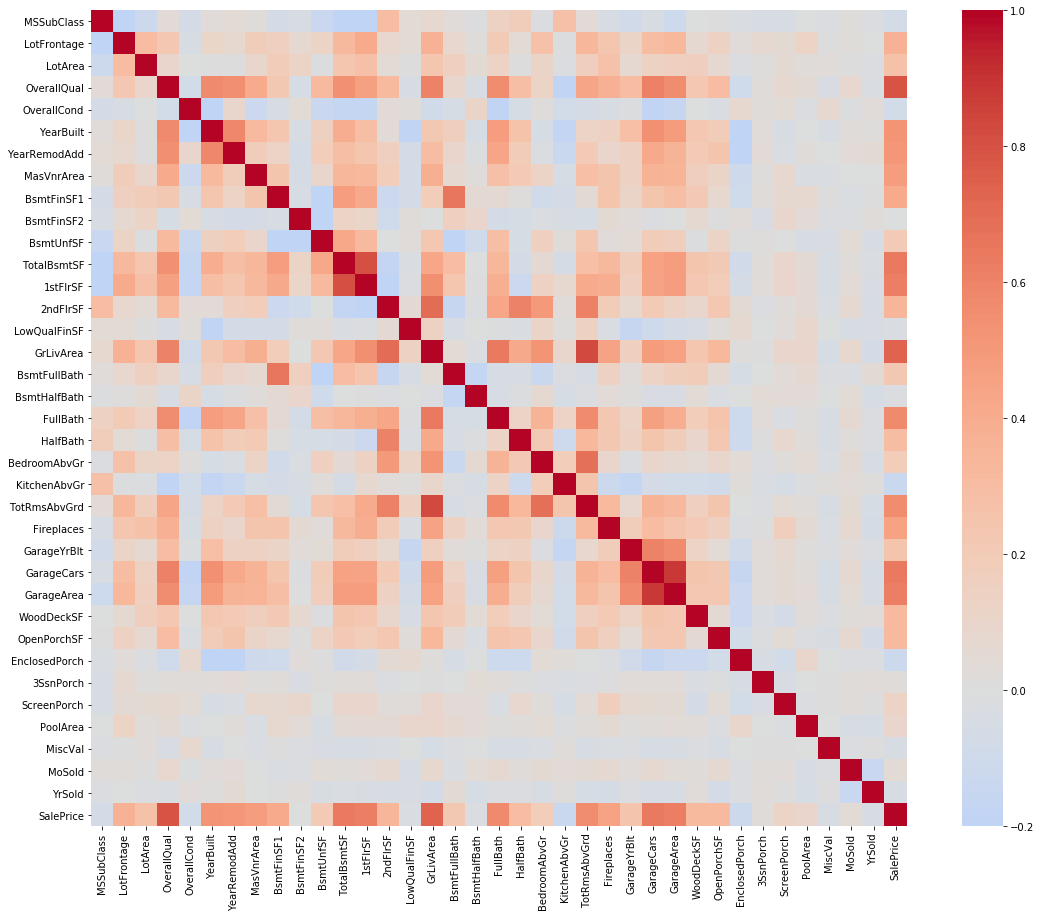

In [10]:
plt.figure(figsize=(20,15))
corr = houseDataDF.corr()

sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            vmin=-0.2, square=True, center=0,cmap='coolwarm'
           )

We can see that the sale price of a house higly depends on the overall quality of the house and the above ground living area. This is as expected. We plot a ordered list of the correlation between SalePrice and the other features below, to get a better view of the most important features.

In [11]:
#corr.iloc[-1].sort_values(ascending=False))
corrAsList = list(zip(corr.tail(1).values[0],list(corr)))
sortedCorr = sorted(corrAsList,key=lambda x : x[0],reverse=True)
corrDF = pd.DataFrame(data=np.array(sortedCorr),columns=["Correlation","Feature"])
highestCorrFeatures = corrDF["Feature"].values[1:11]
corrDF

,Correlation,Feature
0,1.0,SalePrice
1,0.7891424854776941,OverallQual
2,0.7403792470454845,GrLivArea
3,0.6419166279661711,TotalBsmtSF
4,0.64096125033065,GarageCars
5,0.6233291704658925,GarageArea
6,0.6185556125238022,1stFlrSF
7,0.5718673954241766,FullBath
8,0.5594350061389467,TotRmsAbvGrd
9,0.5231935965259926,YearBuilt


All the top features are mainly related to the house's size with some exceptions such as YearBuilt. This is as we expect. 

## Lets plot some features <a name="subparagraph3"></a>

https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python

# Todo: Rewrite tense

Now its time to plot some of the features to get a better understanding of their relationship with other features and the sales price. We will also be looking for skewed features, linear and polynomial relationships with SalePrice, and possible new features for us to engineer. Lets first take a look at the sales price, and its distribution.

### SalePrice

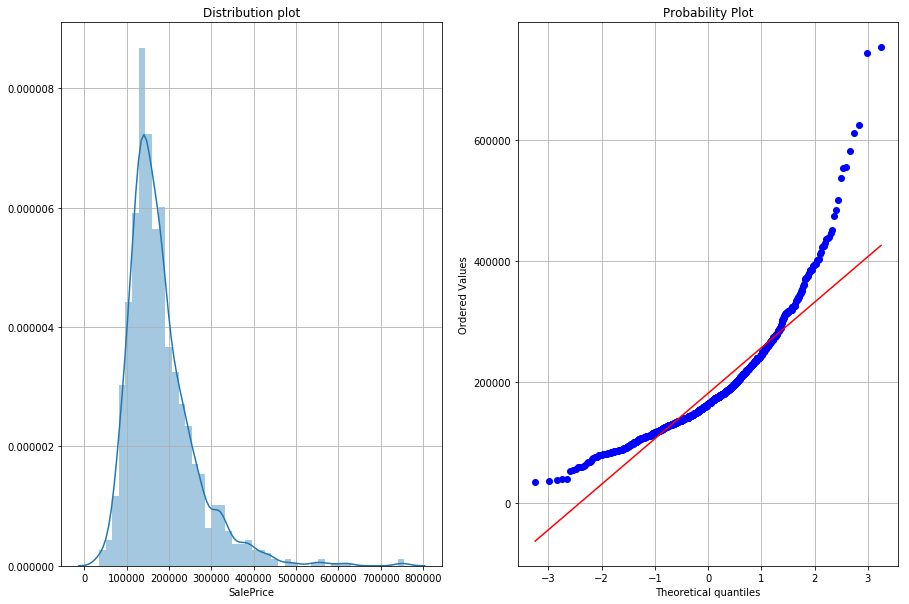

In [13]:
plt.figure(figsize=(15,10))

plt.subplot(121)
plt.title("Distribution plot")
sns.distplot(pd.Series(houseDataDF.SalePrice.values,name="SalePrice"))
plt.grid()

plt.subplot(122)
stats.probplot(houseDataDF.SalePrice, plot=plt)
plt.grid()

# Gir dette egentlig mening? (Biased towards the mean of the distribution => ingen bias)

As we see from the plots above the distribution of SalePrice is quite skewed. This may effect our probaility to predict the house prices, as the price will be biased towards lower values. To counteract this we are log transforming the SalePrice.

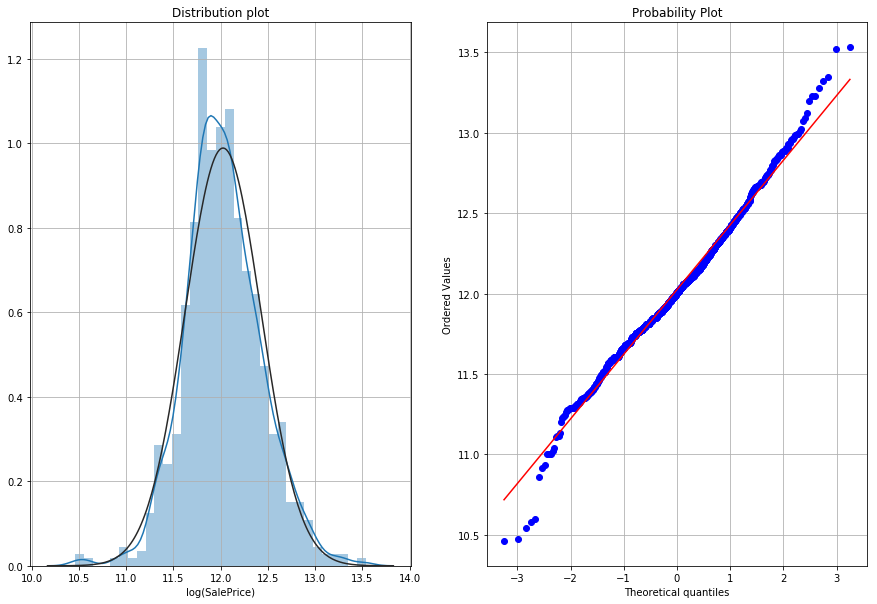

In [14]:
plt.figure(figsize=(15,10))

plt.subplot(121)
plt.title("Distribution plot")
sns.distplot(pd.Series(np.log(houseDataDF.SalePrice.values), name="log(SalePrice)"), fit=norm)
plt.grid()

plt.subplot(122)
stats.probplot(np.log(houseDataDF.SalePrice.values), plot=plt)
plt.grid()

# TODO: Lack of axis names.

After taking the log transform SalePrices looks more like a Gaussian distributed, unbiased variable. We observe that very low and very high priced houses does not fit the distribution particularly well. We address this challenge later in the lab. 

### Top four highest correlated features to SalePrice

Plotting the top four most important features to look for iregularities.

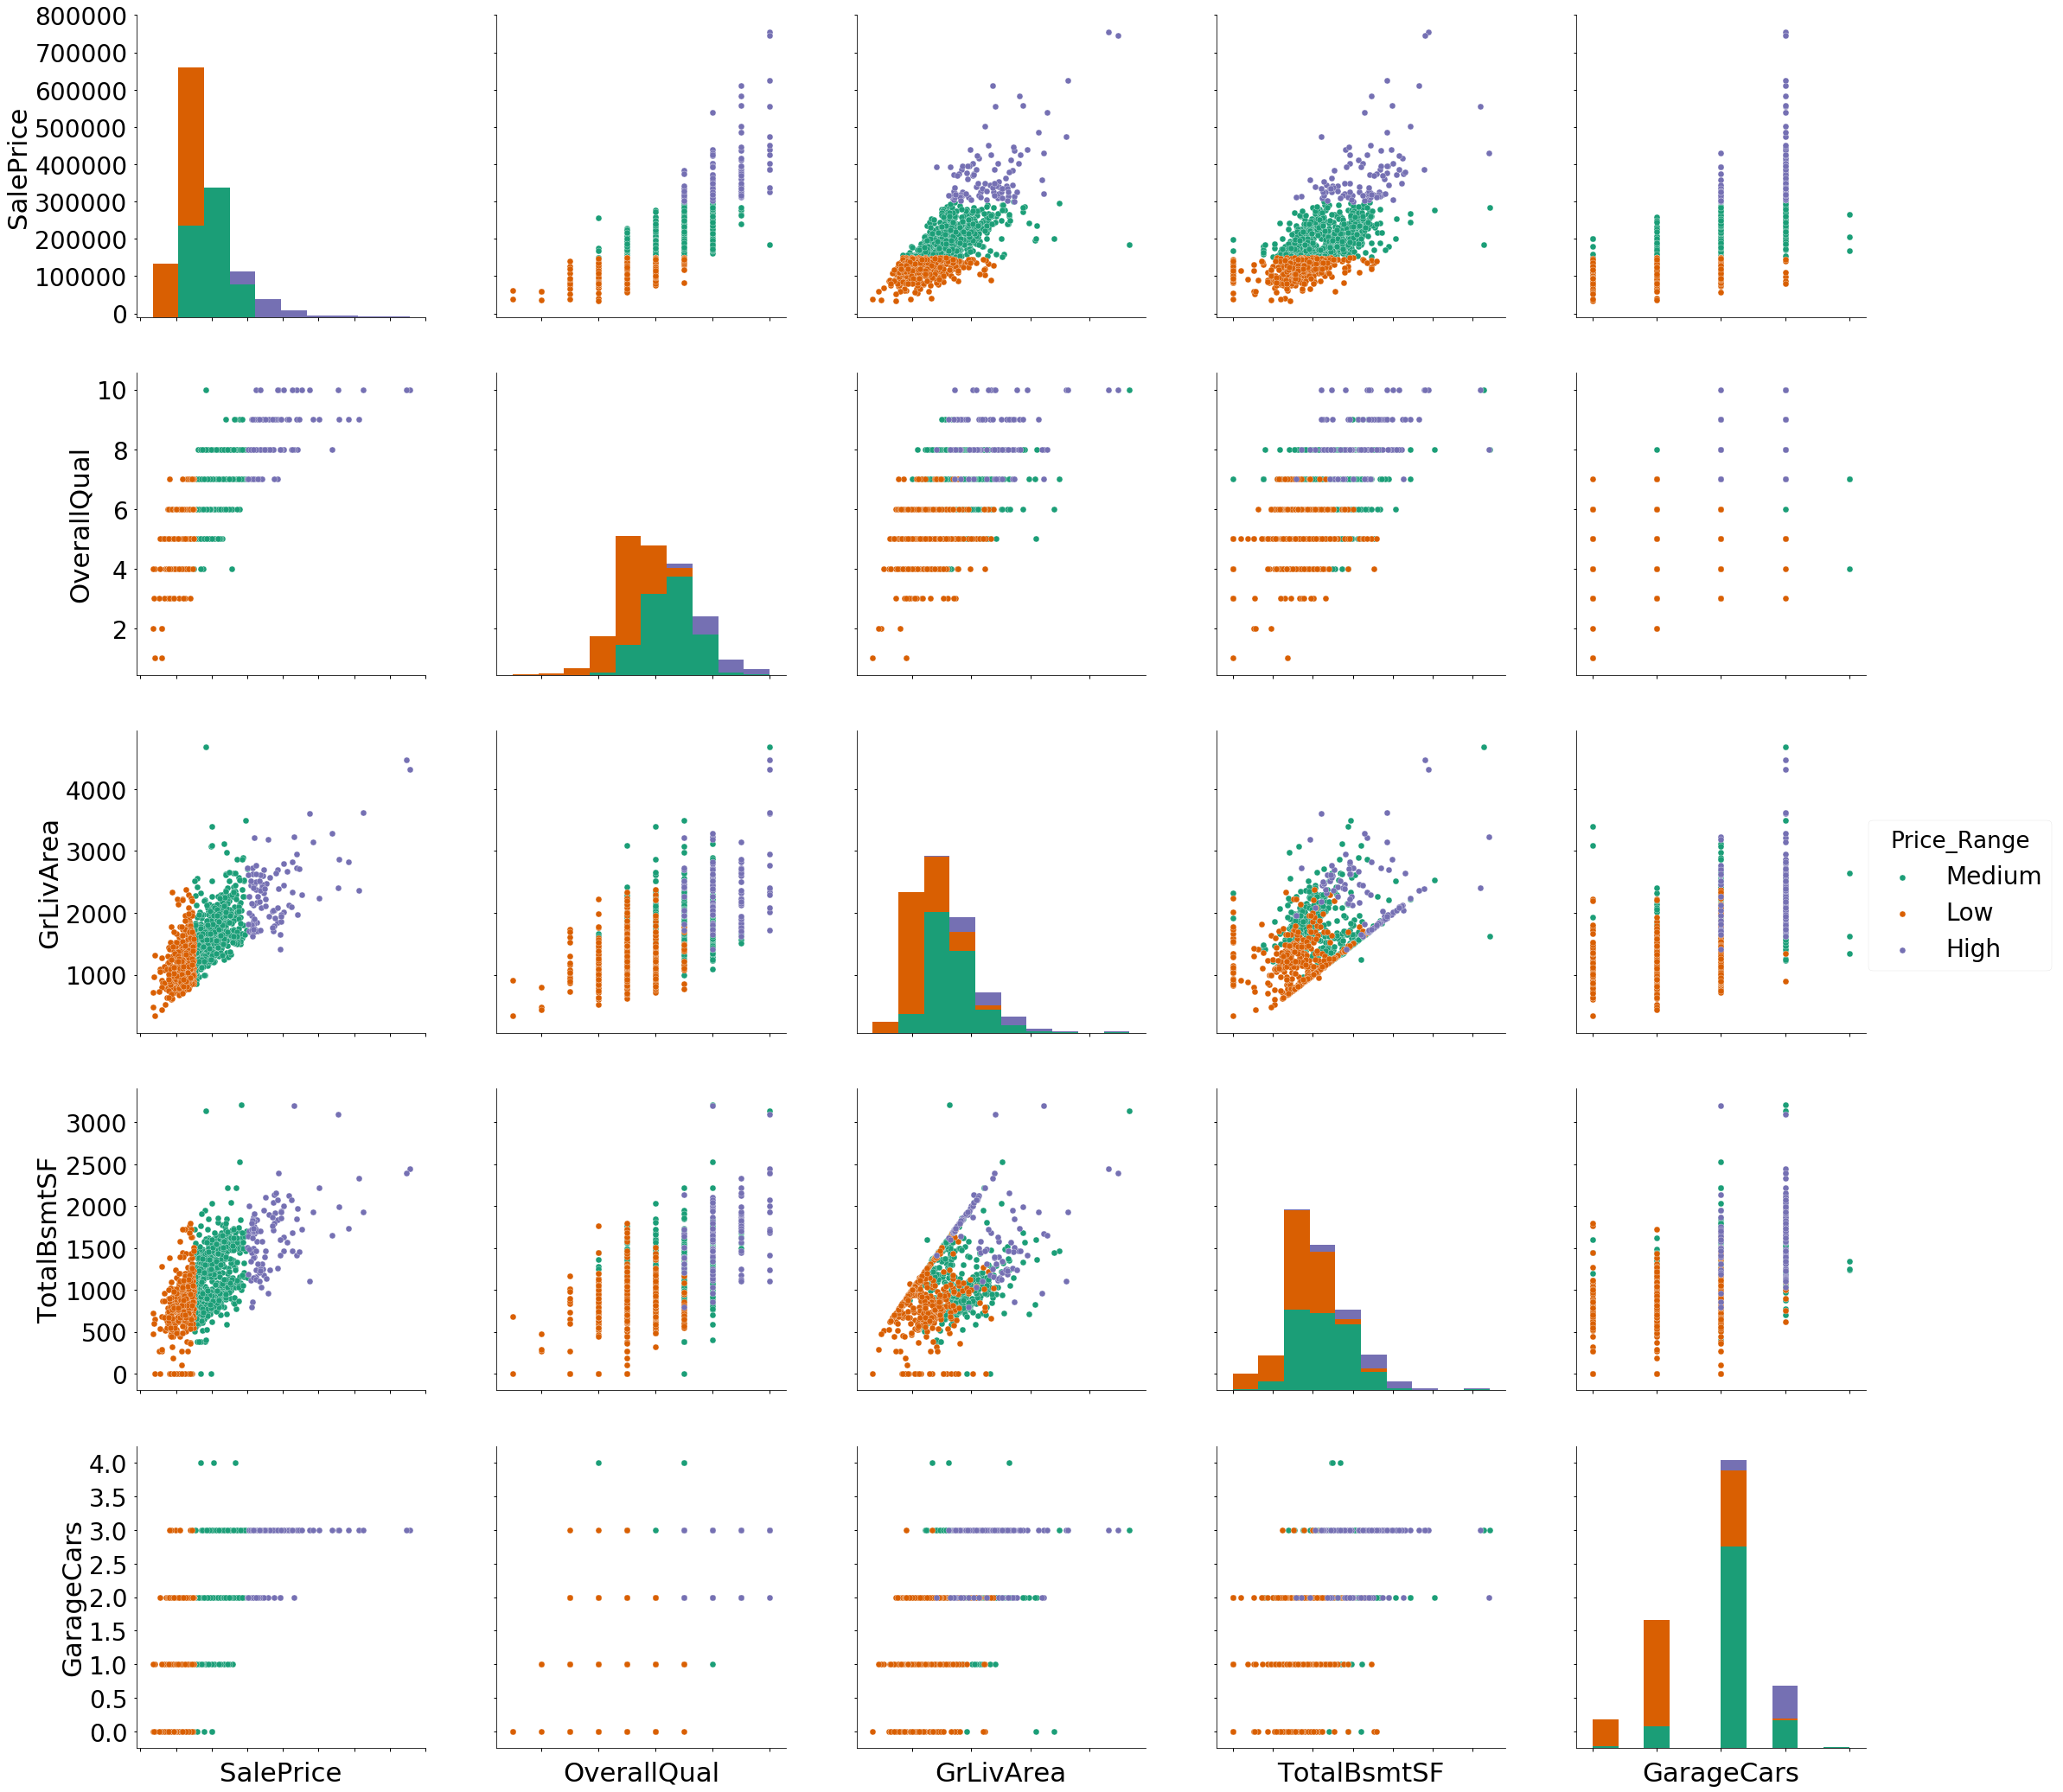

In [15]:
# Place sale price in a category
def findPriceRange(x):
    if x < 150000:
        return "Low"
    if x < 300000:
        return "Medium"
    
    return "High"

# Add price range category to each entry
houseDataDF["Price_Range"] = [findPriceRange(x) for x in houseDataDF.SalePrice]

# Get top 5 features correlated with SalePrice
features = corrDF["Feature"].values[:5]

# Make pairplot with top 5 features and Price_Range
with sns.plotting_context("notebook",font_scale=2.8):
    g = sns.pairplot(houseDataDF,vars=features,palette="Dark2", size=6,hue="Price_Range")
    
g.set(xticklabels=[]);
plt.show()

From all the features plotted above we see that bigger is better, which is not all that surprising and consistend with the highest correlating features from above. We also notice in the basement SF plots, that many have a zero value. This may indicate that they do not have a basement.

### OverallQual

Overall quality was the highest correlated feature with regards to the SalePrice. When people are looking for a new home they want something, that looks nice and is in good condition. So it is quite obvious that the overall quality is very inportant in determining the SalePrice.

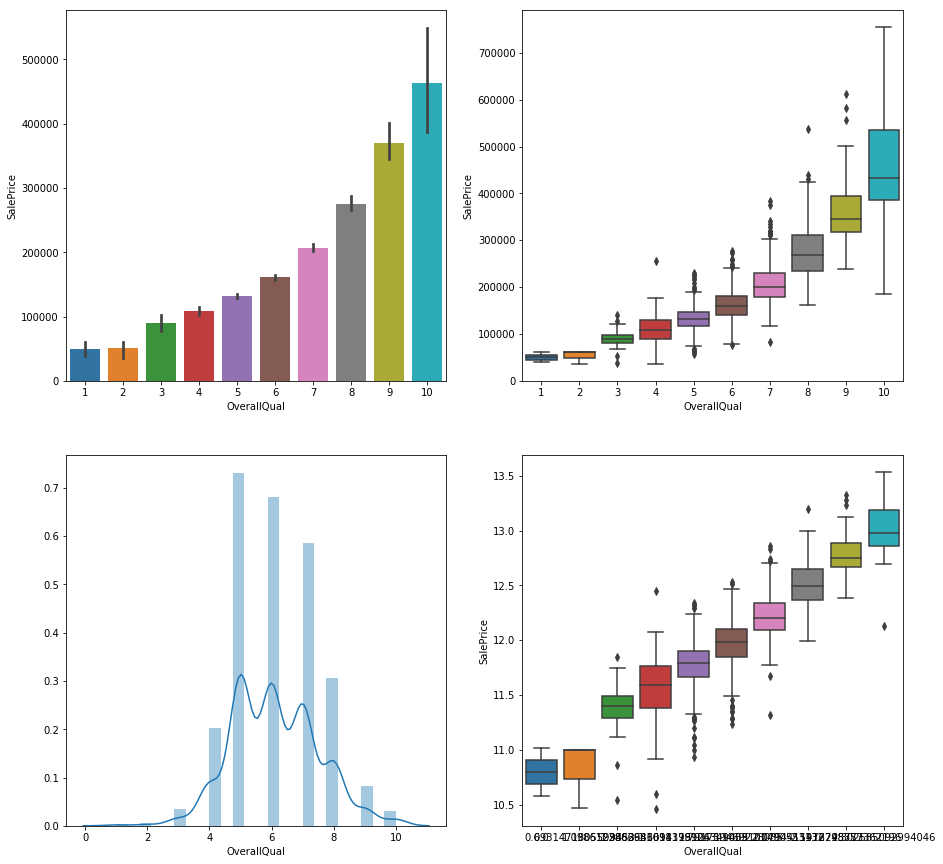

In [16]:
plt.figure(figsize=(15,15))
plt.subplot(221)
sns.barplot(x="OverallQual", y="SalePrice", data=houseDataDF)
plt.subplot(222)
sns.boxplot(x='OverallQual',y='SalePrice', data=houseDataDF)
plt.subplot(223)
sns.distplot(houseDataDF.OverallQual)
plt.subplot(224)
sns.boxplot(x=np.log(houseDataDF.OverallQual),y=np.log(houseDataDF.SalePrice))

From the plots above we can see that the relationship between OverallQual and SalePrice is non-linear. This is fixed by taking the log transform of the SalePrice as shown in the last plot.

### Area features

Our data contains several features that are measures of different sizes of the properties. These features correlates highly with the sales price, so lets look at them to see if we can find some interesting relations.

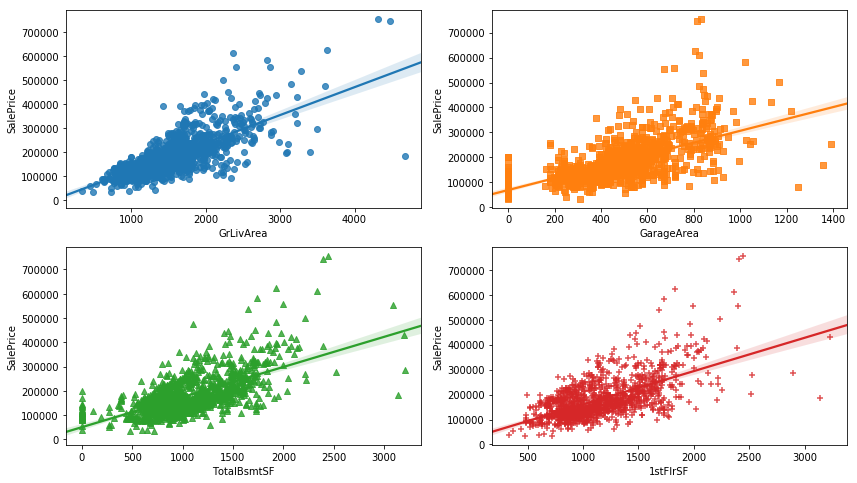

In [17]:
fig, ((ax1, ax2), (ax3, ax4))= plt.subplots(nrows=2, ncols=2, figsize=(14,8))

data = pd.concat([houseDataDF['SalePrice'], houseDataDF['GrLivArea']], axis=1)
sns.regplot(x='GrLivArea', y='SalePrice', data=data, fit_reg=True, ax=ax1)
 
data = pd.concat([houseDataDF['SalePrice'], houseDataDF['GarageArea']], axis=1)
sns.regplot(x='GarageArea', y='SalePrice', data=data, fit_reg=True, ax=ax2, marker='s')

data = pd.concat([houseDataDF['SalePrice'], houseDataDF['TotalBsmtSF']], axis=1)
sns.regplot(x='TotalBsmtSF', y='SalePrice', data=data, fit_reg=True, ax=ax3, marker='^')

data = pd.concat([houseDataDF['SalePrice'], houseDataDF['1stFlrSF']], axis=1)
sns.regplot(x='1stFlrSF', y='SalePrice', data=data, fit_reg=True, ax=ax4, marker='+')

plt.show()

By the plots above we see that all the four features correlates positivly with the sales price. Both "GarageArea" and "TotalBsmtSF" have a lot of zero values which probably indicated that the property do not have a garage or a basement. We can also see that there may be some outliers here when the feature values are wery high. 

We know that "OverallQual" is one of most correlated features with "SalePrice", so lets try to add "OverallQual" to the "GrLivArea" plot to see if the quality of the property is effecting the potential outliers we found earlier.

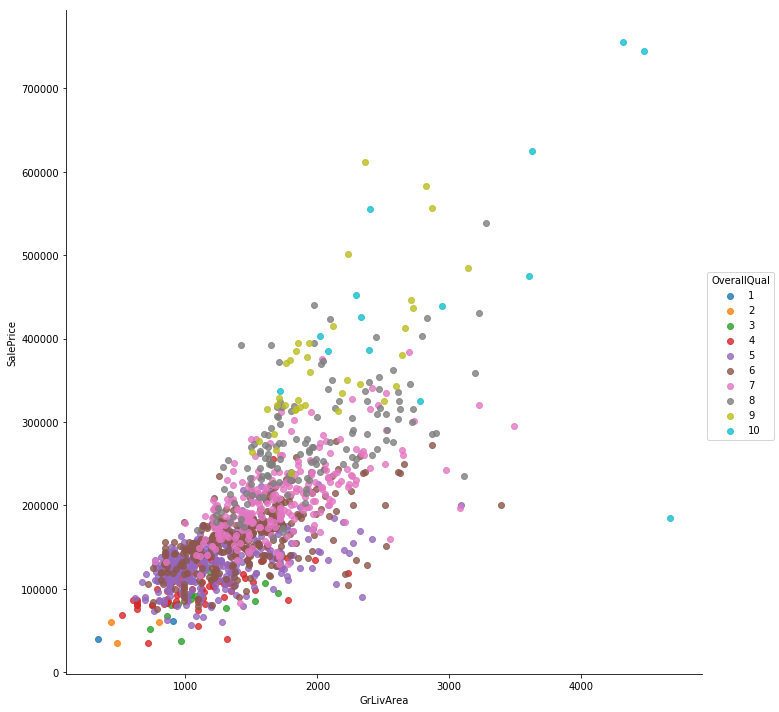

In [18]:
sns.lmplot(x="GrLivArea",y="SalePrice",data=houseDataDF,fit_reg=False,size=10,hue="OverallQual") 

So here we see that a house with GrLivArea above 4000 and a OverallQual of 10 is sold at a price around 2000000. This is most likely an outlier, so we will remove it later before starting to train our models.

In [114]:
#Find the outlier from the plot above.
res = houseDataDF.query('SalePrice <= 200000 & OverallQual == 10 ')[highestCorrFeatures]
outliers = res.index.values
res

,OverallQual,GrLivArea,TotalBsmtSF,GarageCars,GarageArea,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd
Id,,,,,,,,,,
524,10,4676,3138,3,884,3138,3,11,2007,2008


The enty with id 524 is an outlier. It will be removed later.

### Time related features

Our dataset contains several features that are related to time like "Month sold", "Year sold", "Year buildt" and "Year remodeled". These are most likely very important for the determining the correct SalePrice, We plot them to see if we can find some interesting connections. 

We already know from the correlation map from earlier that "YearBuilt" and "SalePrice" are strongly positivly correlated. We still want to check them visually for irregularities. This is done below.

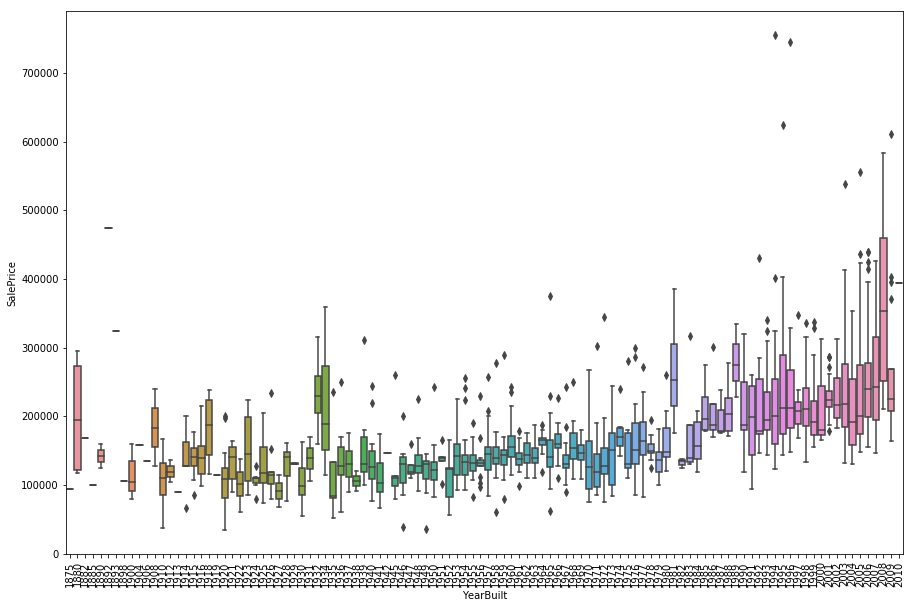

In [20]:
plt.figure(figsize=(15,10))
plt.xticks(rotation='90')
ax = sns.boxplot(x='YearBuilt',
               y='SalePrice', 
               data=houseDataDF)

We can see that some of the years have a higher SalePrice than expected, but this plot is not enough to determine the reason, which may be complex. We can see by the plot is that newer houses often tend to have a higher SalePrice than older ones on average. This is consistent with the correclation coefficient between SalePrcie and YearBuild of 0.52.

In [115]:
#h = sns.lmplot(x="YearBuilt",y="SalePrice",data=houseDataDF,fit_reg=True,size=10) Skal dette bort?

Our dataset contains sales from the years 2006 to 2010. Lets look at the sales year, and its relationship with the sales price.

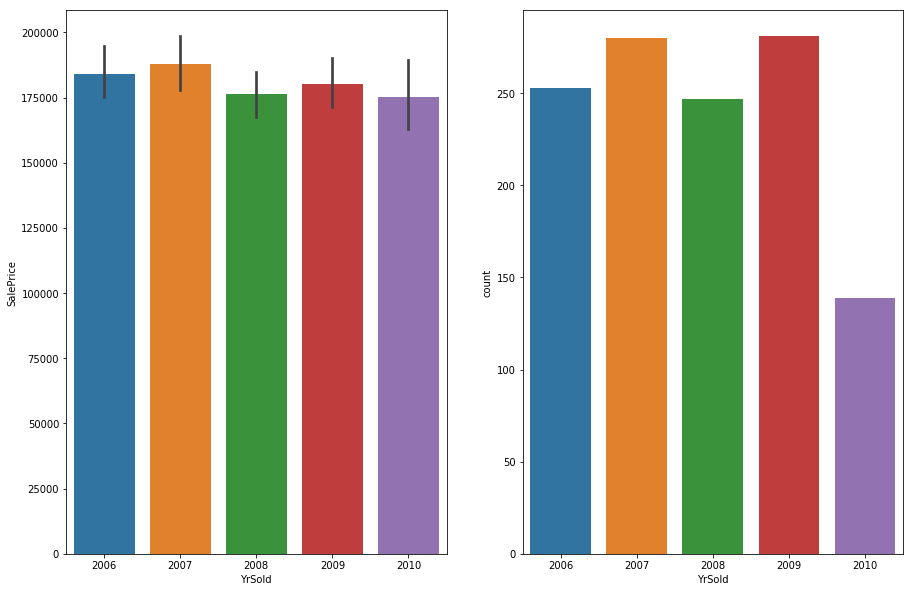

In [22]:
plt.figure(figsize=(15,10))
plt.subplot("121")
sns.barplot(x='YrSold',y='SalePrice', data=houseDataDF)
plt.subplot("122")
sns.countplot(x="YrSold", data=houseDataDF)
plt.show()

There seems to be no notable differences in sales price between sales years. So the year the house was sold will have little impact on the predictions. 

The dataset contains far fewer houses sould in 2010 than in any other year. This is not representative as the number of vacant housing units for sale in the US did not go significantly down during the period. <cite>[1]</cite> The inflation increased by about 11.6% from the beginning of 2006 until the end of 2010 and we had the financial crisis in 2008. These are inverse effects which may counteract each other to some extent and partially explain why the housing prices allmost remained constant. <cite>[2]</cite>

We do the same for month sold (MoSold).

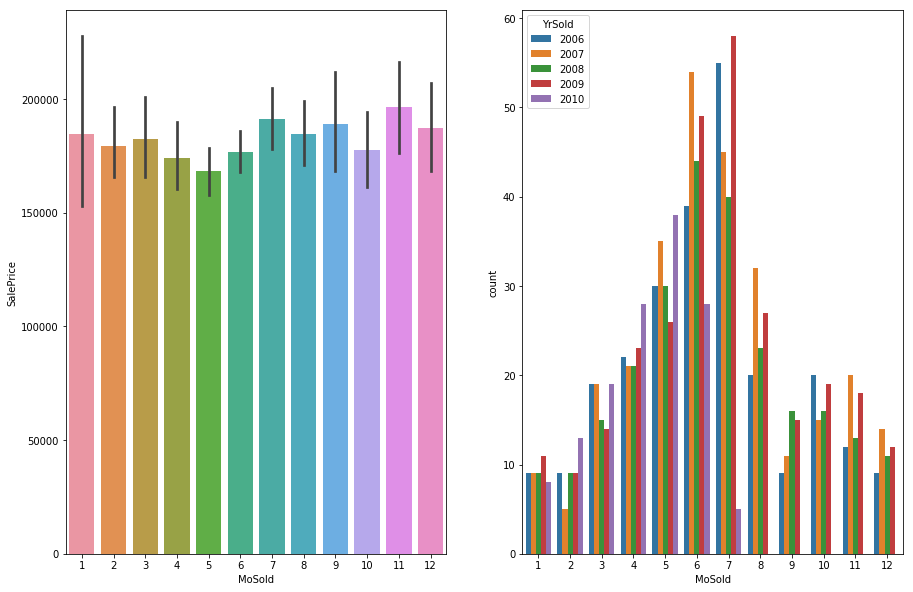

In [23]:
plt.figure(figsize=(15,10))
plt.subplot("121")
sns.barplot(x='MoSold',y='SalePrice', data=houseDataDF)
plt.subplot("122")
sns.countplot(x="MoSold", hue="YrSold", data=houseDataDF)
plt.show()

Here we can see that the sommer months are the months with most activity. They also have a sligtly higher average sales price, than the rest of the months. This is consisted with non seasonally adjusted U.S. National Home Price Index. <cite>[3]</cite> This could be important for our predictions.

Earlier we found out that the age of the house is important for the sale price. What if the house has recently been remodeled? Lets look how remodeling age affects the sales price.

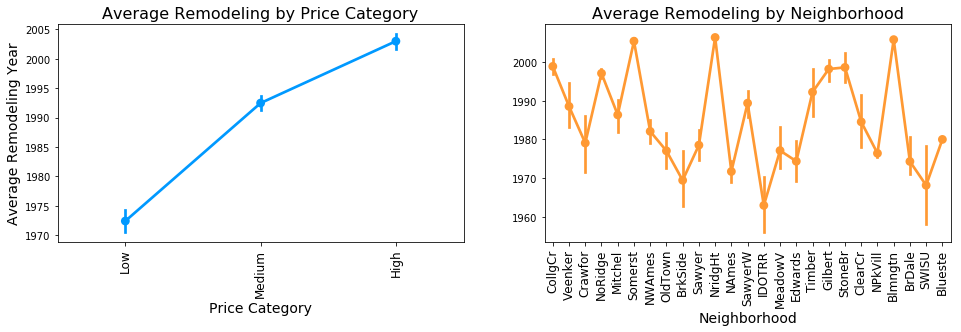

In [24]:
fig, ax = plt.subplots(ncols=2, figsize=(16,4))
plt.subplot(121)
sns.pointplot(x="Price_Range",  y="YearRemodAdd", data=houseDataDF, order=["Low", "Medium", "High"], color="#0099ff")
plt.title("Average Remodeling by Price Category", fontsize=16)
plt.xlabel('Price Category', fontsize=14)
plt.ylabel('Average Remodeling Year', fontsize=14)
plt.xticks(rotation=90, fontsize=12)

plt.subplot(122)
sns.pointplot(x="Neighborhood",  y="YearRemodAdd", data=houseDataDF, color="#ff9933")
plt.title("Average Remodeling by Neighborhood", fontsize=16)
plt.xlabel('Neighborhood', fontsize=14)
plt.ylabel('')
plt.xticks(rotation=90, fontsize=12)
plt.show()

From the plot on the left, we can see that the more expensive the house is, the more resently it has been remodeled. This is as expected, as remodeling helps keep the house up to current standards of trends and regulations. The other plot shows which neighbourhoods that are most resently remodeled. The price in these recently remodeled neighborhoods are expected to be highter than in the others. We take a closer look at neighborhoods next.

### Neighbourhood

Neigbourhood is often inportant for house owners. Some want a property close to a city, or close to public transport, and others wants a large yard and quiet surroundings. We take a look at the neighbourhoods in our dataset to see which ones are the most and least popular. All the neighbourhoods are from the U.S. and most of the seem to be in or close to the state of Iowa.

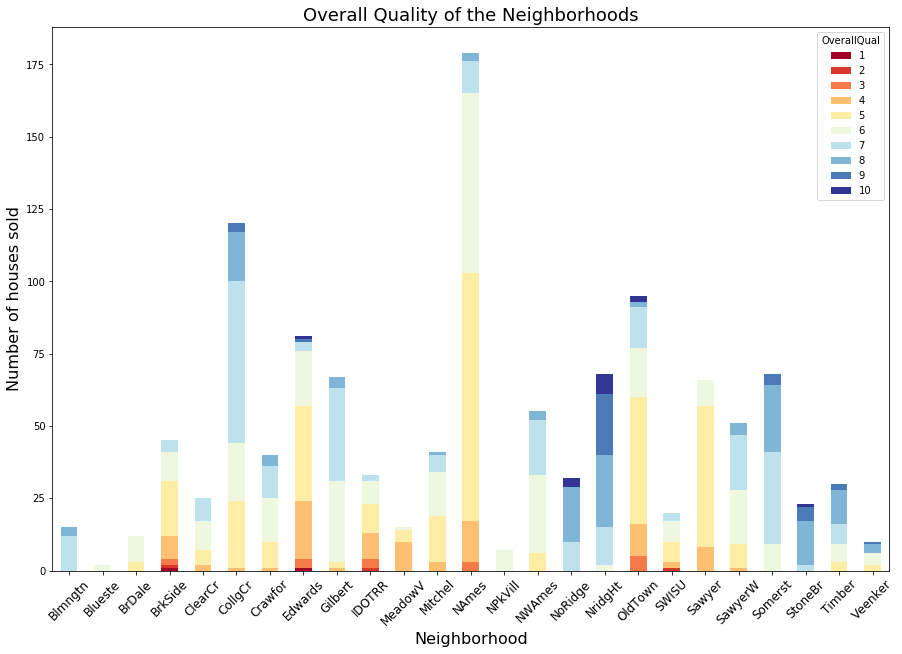

In [25]:
# Find number of houses sold in each quality category for each neighborhood
neighborhood_qual = houseDataDF.groupby(['Neighborhood', 'OverallQual']).size()

# Plot barchart
neighborhood_qual.unstack().plot(kind='bar', stacked=True, colormap='RdYlBu', figsize=(15,10), grid=False)

plt.ylabel('Number of houses sold', fontsize=16)
plt.xlabel('Neighborhood', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.title('Overall Quality of the Neighborhoods', fontsize=18)
plt.show()

NAmes and CollgCr are the neighbourhoods with the highest number of sold houses. NAmes seams to be a middle class neighbourhood, which is probably why there are so many sold houses there. NoRidge, StoneBr and NridgHt seems to be the most high-class neighbourhoods where most of the houses sold are of high quality.

Looking at the SalePrice distribution in each neighbourhood.

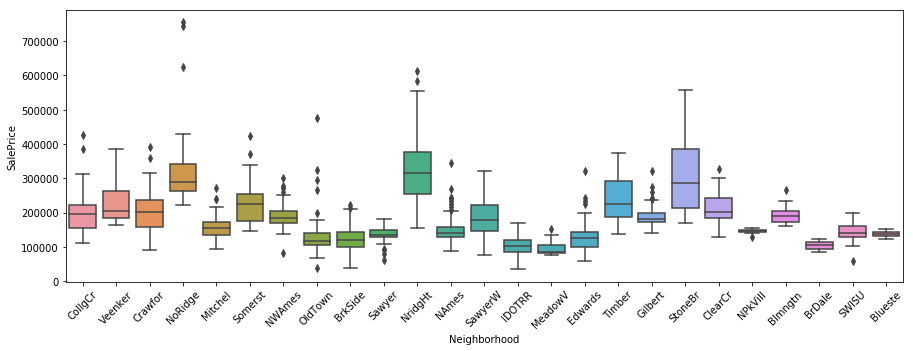

In [26]:
plt.figure(figsize=(15,5))
plt.xticks(rotation='45')
sns.boxplot(x="Neighborhood", y="SalePrice", data=houseDataDF)

We have earlier found out that NoRidge, StoneBr and NridgHt are the most high quality neighbourhoods, and by looking at the SalePrice from the plots above, we can also see that they have the highest average SalePrice. This is expected. 

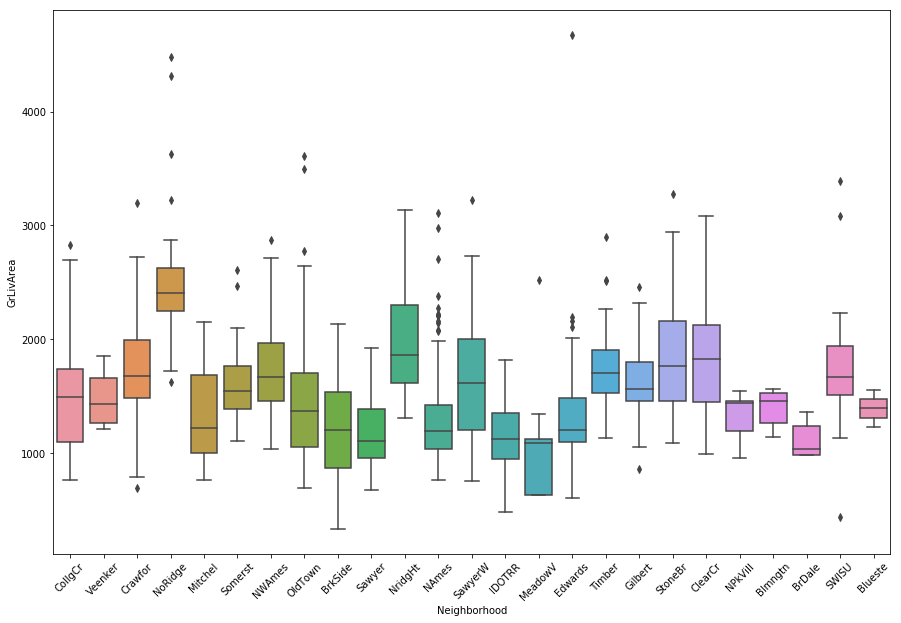

In [27]:
plt.figure(figsize=(15,10))
plt.xticks(rotation='45')
sns.boxplot(x='Neighborhood',
               y='GrLivArea', 
               data=houseDataDF)

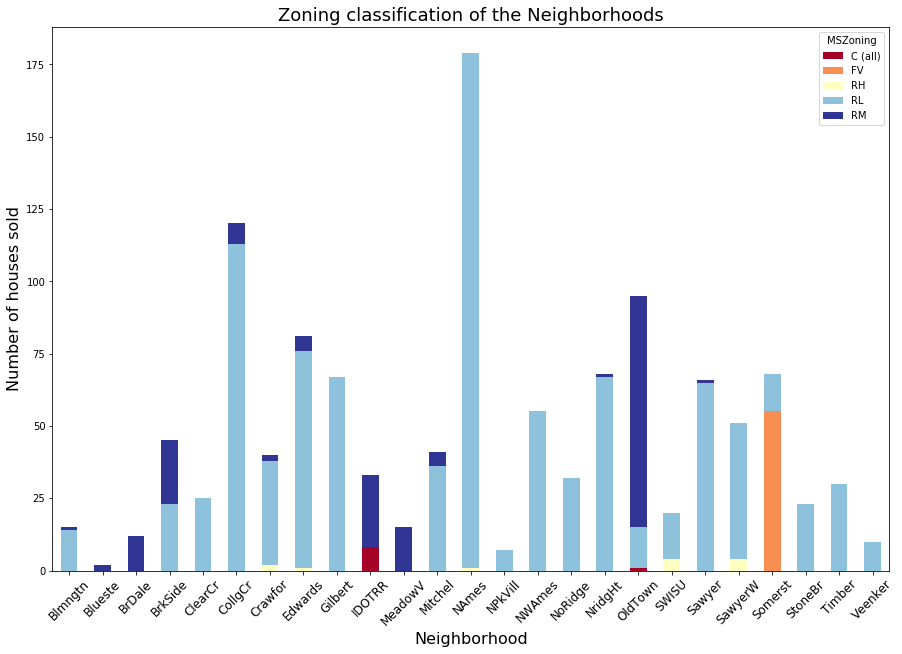

In [28]:
types_zoning = houseDataDF.groupby(['Neighborhood', 'MSZoning']).size()
types_zoning.unstack().plot(kind='bar', stacked=True, colormap='RdYlBu', figsize=(15,10), grid=False)
plt.ylabel('Number of houses sold', fontsize=16)
plt.xlabel('Neighborhood', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.title('Zoning classification of the Neighborhoods', fontsize=18)
plt.show()

In [29]:
houseDataDF = houseDataDF.drop(["Price_Range"],axis=1)

# Cleaning the data <a name="paragraph5"></a>

## Removing outliers <a name="subparagraph4"></a>

Our data seems to contains some outliers, especially one which is a very large house sold at price much lower than it potential value. We will remove this entry to prevent out data to be biased.

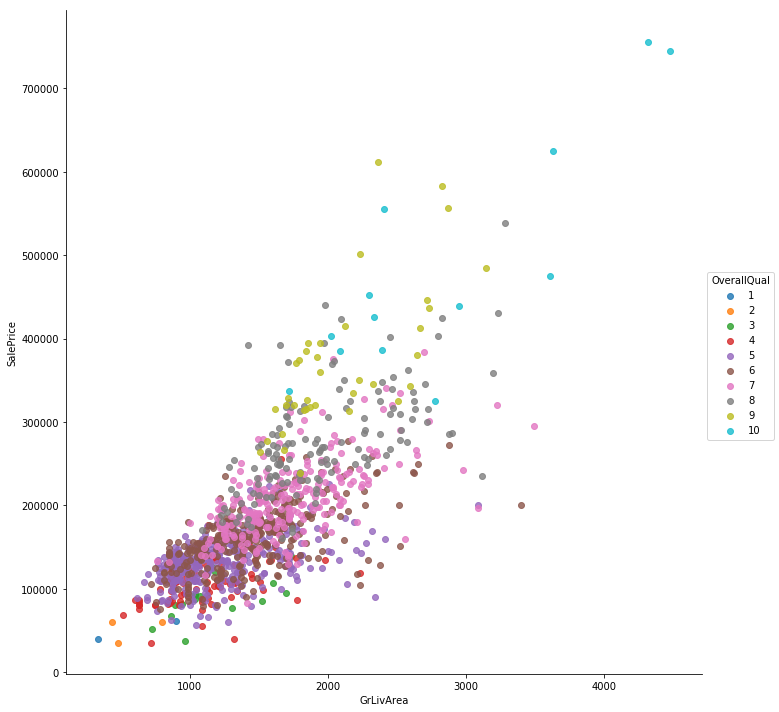

In [30]:
# Drop all the entries with Ids that we found earlier
houseDataCleanedDF = houseDataDF.drop(outliers)
# Plot data after outliers have been removed
sns.lmplot(x="GrLivArea",y="SalePrice",data=houseDataCleanedDF,fit_reg=False,size=10,hue="OverallQual")

Now our dataset looks better.

## Feature engineering <a name="subparagraph5"></a>

Now its time to do some feature engineering. First we are goint to merge the test and training data, so that we are sure that both the datasets are engineered in the same way, and that they contain the same features. Then we are going to one-hot-encode all the categorical features, except "Utilities" and "Alley" which hold no predictive power as discovered earlier. After that its time to create some features on our own. 

In [31]:
# Transform SalePrice and remove it from our training data
y = np.log(houseDataCleanedDF.SalePrice)
houseDataCleanedDF = houseDataCleanedDF.drop(["SalePrice"],axis=1)

# Merge our training and test data into one dataset
houseDataCleanedDF = pd.concat([houseDataCleanedDF,testDF])

In [32]:
def hotEncodeCategoricalFeatures(houseDataDF):
    # find all features that are categorical
    categorical_feats = houseDataDF.dtypes[houseDataDF.dtypes == "object"].index.values
    
    # dummy encode all categorical features
    for feat in categorical_feats:
        if(feat == "Utilities" or feat == "Alley"):
            continue
        
        # make dummy columns
        dummies = pd.get_dummies(houseDataDF[feat], drop_first=True)
        
        # find how many dummy columns that have been made
        num_categories = len(dummies.columns)
        
        # create column name for each column
        houseDataDF[[feat+str(i) for i in range(num_categories)]] = dummies
    
    return houseDataDF
        
    
def makeNewFeatures(houseDataDF):

    houseDataDF['NearPark'] = [1 if x=='PosN' or x=='PosA' or y=='PosN' or y=='PosA' else 0\
        for x,y in zip(houseDataDF['Condition1'],houseDataDF['Condition2'])]

    houseDataDF['Loudness'] = [1 if x=='Feedr' or x=='Artery' or x=='RRAe' or y=='Feedr'\
        or y=='Artery' or y=='RRAe' else 0 for x,y in zip(houseDataDF['Condition1'],houseDataDF['Condition2'])]
    
    houseDataDF['HouseExterior'] = [1 if x == 'ImStucc' or x == 'Stone' or x == 'CemntBd' or y == 'ImStucc'\
        or y == 'Stone' or y == 'CemntBd' else 0 for x,y in zip(houseDataDF['Exterior1st'],houseDataDF['Exterior2nd'])]
    
    houseDataDF['TotalSF'] = houseDataDF['TotalBsmtSF'] + houseDataDF['1stFlrSF'] + houseDataDF['2ndFlrSF']
    
    houseDataDF['TimeBetweenRemodAndBuild'] =  [x-y for x,y in zip(houseDataDF["YearRemodAdd"],houseDataDF["YearBuilt"])]
    
    houseDataDF['RemodeledResent'] =  [1 if x != y and 2010 - x < 10 else 0 for x,y in zip(houseDataDF["YearRemodAdd"],houseDataDF["YearBuilt"])]
    
    houseDataDF['Age'] =  [2010 - x for x in houseDataDF["YearBuilt"]]
    
    houseDataDF['AvgQualCond'] =  [(int(x)+int(y))/2 for x,y in zip(houseDataDF["OverallQual"],houseDataDF["OverallCond"])]
    
    houseDataDF['TotalPorchSF'] = houseDataDF['OpenPorchSF'] + houseDataDF['EnclosedPorch'] + houseDataDF['3SsnPorch'] + houseDataDF['ScreenPorch']
    
    houseDataDF['SoldDuringFinancialCrisis'] = [1 if x == 2008 or (x == 2007 and y >= 8) else 0 for x,y in zip(houseDataDF["YrSold"],houseDataDF["MoSold"] )]
    
    houseDataDF['NoGarage'] = [1 if x == 0 else 0 for x in houseDataDF["GarageArea"]]
    
    houseDataDF['BuildtAndSoldDuringCrisis'] = [1 if (x-y) <= 1 and x == 2008 else 0 for x,y in zip(houseDataDF["YrSold"],houseDataDF["YearBuilt"])]
    
    houseDataDF['BuildtDuringCrisis'] = [1 if x == 2008 else 0 for x in houseDataDF["YearBuilt"]]
    
    houseDataDF['HighQualSoldDuringCrisis'] = [1 if y >= 9 and (x == 2008 or x == 2007) else 0 for x,y in zip(houseDataDF["YrSold"],houseDataDF["OverallQual"])]
    
    houseDataDF['HighAreaSoldDuringCrisis'] = [1 if y >= 3000 and (x == 2008 or x == 2007) else 0 for x,y in zip(houseDataDF["YrSold"],houseDataDF["GrLivArea"])]
    
    houseDataDF['HighSFSoldDuringCrisis'] = [1 if y >= 1000 and (x == 2008 or x == 2007) else 0 for x,y in zip(houseDataDF["YrSold"],houseDataDF["TotalSF"])]    
    
    houseDataDF['TotalArea'] = houseDataDF['GrLivArea'] + houseDataDF['LotArea'] + houseDataDF['MasVnrArea'] + houseDataDF['GarageArea'] + houseDataDF['PoolArea']
    
    return houseDataDF
    
houseDataCleanedDF = hotEncodeCategoricalFeatures(houseDataCleanedDF)
houseDataCleanedDF = makeNewFeatures(houseDataCleanedDF)
# TODO : Add feature for centrality

Now that we have added some custom features lets take a look at how they covary with eachother and with the SalePrice.

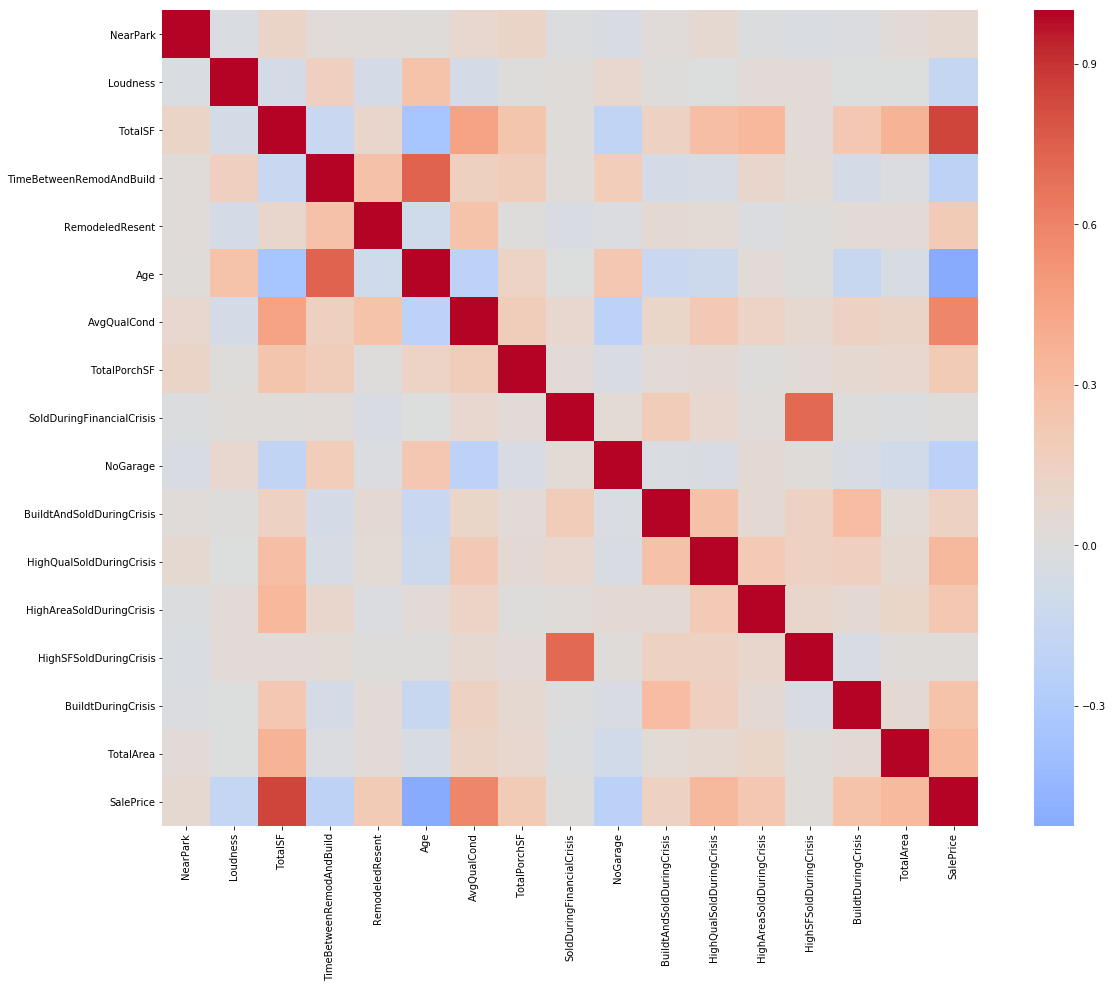

In [33]:
customFeatures = ['NearPark','Loudness','TotalSF','TimeBetweenRemodAndBuild','RemodeledResent',\
                  'Age','AvgQualCond','TotalPorchSF',\
                  'SoldDuringFinancialCrisis','NoGarage','BuildtAndSoldDuringCrisis',\
                  'HighQualSoldDuringCrisis','HighAreaSoldDuringCrisis','HighSFSoldDuringCrisis',\
                  'BuildtDuringCrisis','TotalArea']

# find all the columns with custom features
customFeaturesDF = houseDataCleanedDF[customFeatures]

# transform saleprice back to original values
customFeaturesDF["SalePrice"] = np.exp(y)

# find correlation between new features
corr = customFeaturesDF.corr()

plt.figure(figsize=(20,15))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            square=True, center=0,cmap='coolwarm',
           )

We can see that our new features are covariating to different degrees with the SalePrice. We are going to keep them all for now, before maybe filtering some of them away later in this lab.

## Fixing skew <a name="subparagraph6"></a>

To deal with skewness in our features we are going to use boxcox transforms on all of our numerical features that have a skewness above 0.75. The boxcox transform is defined as follows:
$$y(x,\lambda)=\frac{(1+x)^\lambda - 1}{\lambda}$$ for $$\lambda \neq 0$$ else $$y(x,\lambda) = log(1+x)$$

In [34]:
def fixSkew(houseDataDF,verbose=0):
    # Find all numerical features
    numeric_feats = houseDataDF.dtypes[houseDataDF.dtypes != "object"].index

    # Check the skew of all numerical features
    skewed_feats = houseDataDF[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
    
    skewness = pd.DataFrame({'Skew' : skewed_feats})
    
    # Find the features that have a large skew, and that need to be corrected
    skewness = skewness[abs(skewness) > 0.75]
    
    if verbose != 0:
        print("\nSkew in numerical features: \n")
        print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

    # Find the name of the skewed features
    skewed_features = skewness.index

    lam = 0.15
    
    for feat in skewed_features:
        # Dont wont to transform these. Strange things happens. SalePrice is log transformed
        if(feat not in ["SalePrice","YearBuilt","HousePriceIndex","Vacency","USBonds"]):
            houseDataDF[feat] = boxcox1p(houseDataDF[feat], lam)
            
    return houseDataDF

houseDataCleanedDF = fixSkew(houseDataCleanedDF)

# Predictions <a name="paragraph6"></a>

https://datascienceplus.com/linear-regression-in-python-predict-the-bay-areas-home-prices/
https://www.kaggle.com/dougdaly/house-price-modeling-with-random-forest-regressors
https://shankarmsy.github.io/stories/gbrt-sklearn.html
https://www.kaggle.com/nolberg/machine-learning-for-house-price-prediction
https://kaggle2.blob.core.windows.net/forum-message-attachments/216792/7200/MDSSKaggle_Slides_Henry.pdf
https://www.kaggle.com/erikbruin/house-prices-lasso-xgboost-and-a-detailed-eda
https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
https://www.kaggle.com/jimthompson/ensemble-model-stacked-model-example
https://www.kaggle.com/janiobachmann/in-depth-analysis-house-prices-ensembling
https://www.kaggle.com/agodwinp/stacking-house-prices-walkthrough-to-top-5/notebook
https://rasbt.github.io/mlxtend/user_guide/regressor/StackingRegressor/
https://stats.stackexchange.com/questions/139042/ensemble-of-different-kinds-of-regressors-using-scikit-learn-or-any-other-pytho?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa

For your coefficients to be interpretable, linear regression assumes a bunch of things. One of these things is no multicollinearity. That is, your X variables should not be correlated against each other. That is why we are goint to drop some of our features that we know are higly correlated with other features.

In [35]:
# keep only features that are numerical
data = houseDataCleanedDF.select_dtypes(include=[np.number]).interpolate().dropna()

# remove features we know are highly correlated with others
drop_cols = ["YearBuilt",'YearRemodAdd', 'GarageYrBlt', 'GarageArea', 'TotalBsmtSF', 'BsmtFinSF1']
data = data.drop(drop_cols,axis=1)

# remaining columns
columns = data.columns.values

# find length of original training set
currentTrainSetLenght = trainSetLength - len(outliers)

# split data back into training and test data
trainData = pd.DataFrame(data=data.values[:currentTrainSetLenght],columns=columns)

testData = pd.DataFrame(data=data.values[currentTrainSetLenght:],columns=columns)

In [36]:
X = trainData
training_features = X.columns.values

We are goint to splitt our training data into two different sets. One smaller training set, and one test set. This makes us able to verify the accuracy of our algorithm on the test data we know the answer to. We are later taking this one step further and be using cross-validation later in the lab.

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
                                    X, y, random_state=42, test_size=.2)

To optimize our models further we may neet to do some hyperparameter tuning. To do this we are using sklearns GridSearch, and a custom params grid for all the models that require tuning.

In [38]:
# http://optunity.readthedocs.io/en/latest/notebooks/notebooks/sklearn-svr.html
def hyperparameterTuning(estimator,param_grid,cv,n_jobs=4): 
    classifier = GridSearchCV(estimator=estimator, cv=cv, param_grid=param_grid, n_jobs=n_jobs,verbose=1)
    classifier.fit(X_train, y_train)
    print("Best Estimator learned through GridSearch")
    print(classifier.best_estimator_)
    return classifier.best_estimator_

To help us counteract overfitting we will plot the learning curve of the models. The learning curve shows ut the models prediction ability, as a function of different training set sizes. By looking at the graph we can also see when we need to tune our parameter more or if we have tuned enough, and if we could benefit from more data.

In [39]:
# http://scikit-learn.org/stable/modules/learning_curve.html

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(15,5))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve( estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt

We will use a 10-fold cross-validation sceme to score our models, and when plotting the learning curve for our models.

In [40]:
cv = ShuffleSplit(X_train.shape[0], n_iter=10, test_size=0.2)

## Linear Regression <a name="subparagraph7"></a>

The first model we will use is a simple linear regression model. It uses ordinary least squares to find a linear relationship between the features and the SalePrice. We will print the R^2, RMSE and cross validation score, and use them to compare the different models we are goint to test in this notebook. 

In [41]:
lr = LinearRegression()
linearModel = lr.fit(X_train,y_train)
print ("R^2 is:", linearModel.score(X_test, y_test))

R^2 is: 0.8545862700461266


In [42]:
predictions = linearModel.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print ('RMSE is:',rmse)

RMSE is: 0.14967580082200424


In [43]:
scores = cross_val_score(lr, X_test, y_test, cv=10)
print("Cross validation score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Cross validation score: -1.13 (+/- 3.37)


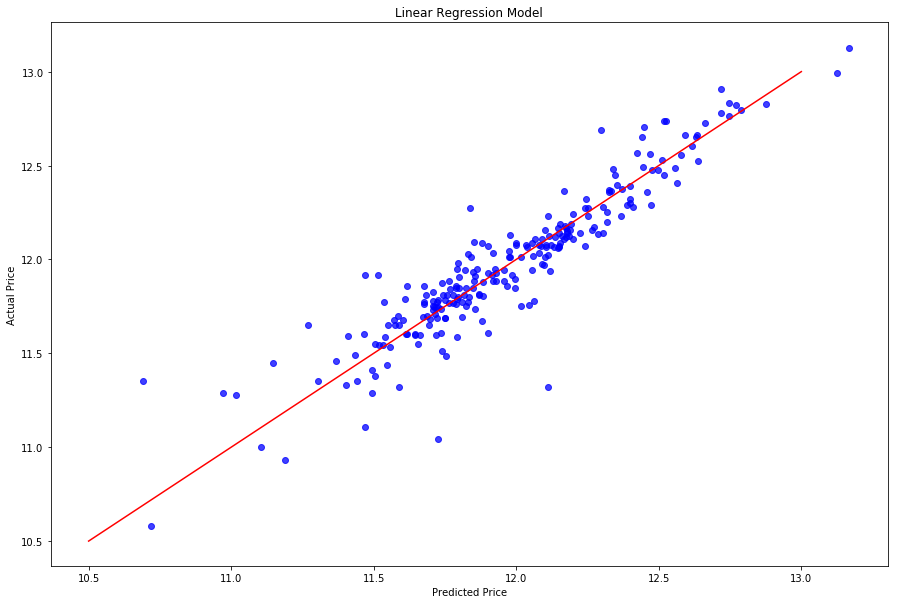

In [44]:
actual_values = y_test
plt.figure(figsize=(15,10))
plt.scatter(predictions, actual_values, alpha=.75,color='b') 
plt.plot([10.5,13],[10.5,13],"r")
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')
plt.show()

In the plot above we can see how our linaer model predicted compared to the actual price. We can see that the predictions follow the red line ,which is the optimal value, quite well for medium to high value houses. But the linar model cant seem to predict low value houses that well. Lets see if other models can catch these errors better.

### KernelRidge Regularization <a name="subparagraph8"></a>

Kernel ridge regression (KRR) combines Ridge Regression (linear least squares with l2-norm regularization) with the kernel trick. It thus learns a linear function in the space induced by the respective kernel and the data. For non-linear kernels, this corresponds to a non-linear function in the original space. 

The form of the model learned by KernelRidge is identical to support vector regression (As we will implement later). However, different loss functions are used: KRR uses squared error loss while support vector regression uses  $\epsilon$-insensitive loss, both combined with l2 regularization. In contrast to SVR, fitting KernelRidge can be done in closed-form and is typically faster for medium-sized datasets. On the other hand, the learned model is non-sparse and thus slower than SVR, which learns a sparse model for $\epsilon$ > 0, at prediction-time.

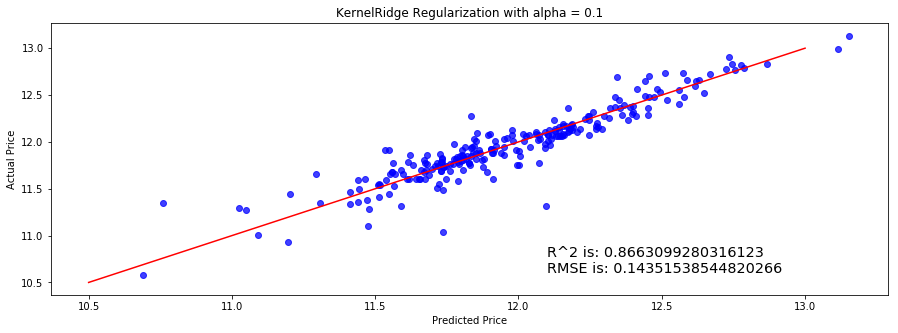

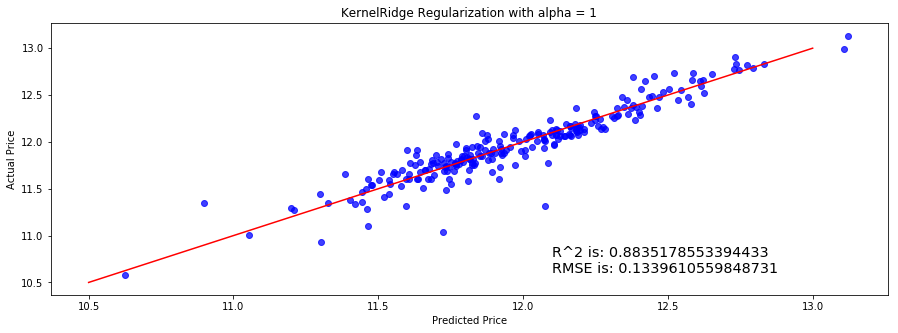

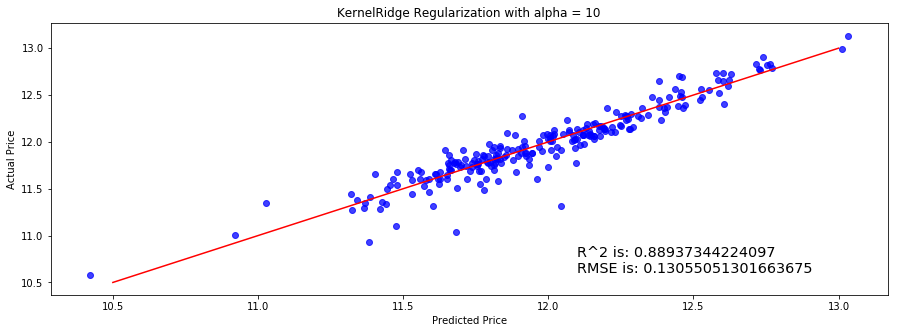

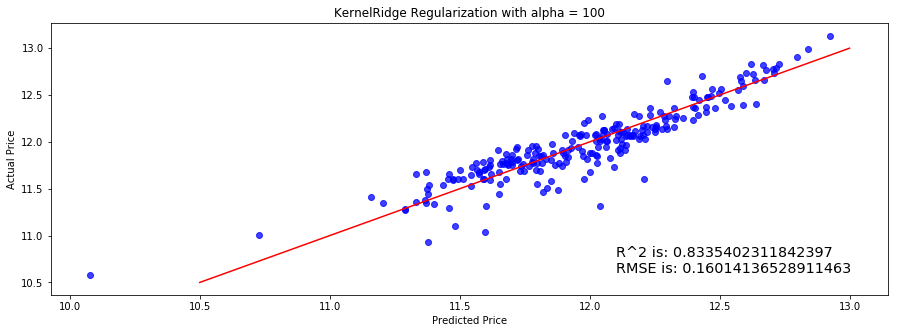

In [45]:
for alpha in [0.1,1,10,100]:
    rm = KernelRidge(alpha=alpha)
    ridge_model = rm.fit(X_train, y_train)
    preds_ridge = ridge_model.predict(X_test)
    
    # plotting
    plt.figure(figsize=(15,5))
    plt.scatter(preds_ridge, actual_values, alpha=.75, color='b')
    plt.plot([10.5,13],[10.5,13],"r")
    plt.xlabel('Predicted Price')
    plt.ylabel('Actual Price')
    plt.title('KernelRidge Regularization with alpha = {}'.format(alpha))
    rmse = np.sqrt(mean_squared_error(y_test, preds_ridge))
    overlay = 'R^2 is: {}\nRMSE is: {}'.format(
                    ridge_model.score(X_test, y_test),
                    rmse)
    plt.annotate(s=overlay,xy=(12.1,10.6),size='x-large')
    plt.show()

In [46]:
rm = KernelRidge(alpha=10)
scores = cross_val_score(rm, X_test, y_test, cv=10)
print("Cross validation score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Cross validation score: 0.83 (+/- 0.23)


By looking at the RMSE values in the plots above, using alpha=10 seems like te best choice. Compared to the linear model, the KernelRidge is much better at predicting the value for low value houses. The R^2 and cross_val_score is also higher which is good. 

## BayesianRidge <a name="subparagraph9"></a>

BayesianRidge estimates a probabilistic model for our problem. The prior for the parameter  w is given by a spherical Gaussian:
$$p(w|\lambda)=N(w|0,\lambda^{-1}I_p)$$
The priors over $\alpha$ and $\lambda$ are chosen to be gamma distributions, the conjugate prior for the precision of the Gaussian. The resulting model is called Bayesian Ridge Regression, and is similar to the classical Ridge. The parameters w, $\alpha$ and $\lambda$ are estimated jointly during the fit of the model. The remaining hyperparameters are the parameters of the gamma priors over $\alpha$ and $\lambda$. These are usually chosen to be non-informative.

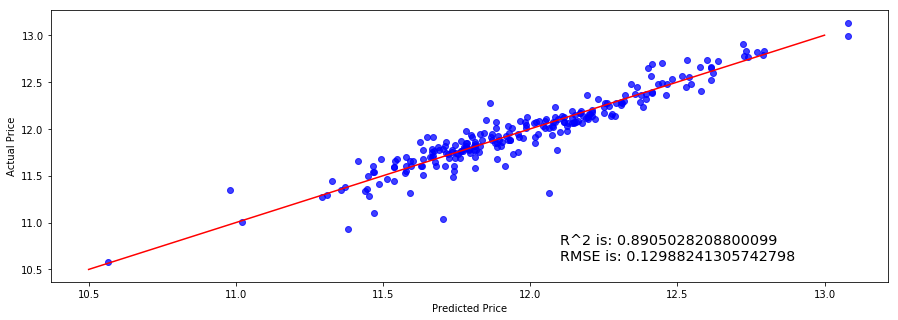

In [47]:
br = BayesianRidge(alpha_1=1e-08,alpha_2=5e-06)
bayesian_model = br.fit(X_train, y_train)
br_preds = bayesian_model.predict(X_test)

# plotting
plt.figure(figsize=(15,5))
plt.scatter(br_preds, actual_values, alpha=.75, color='b')
plt.plot([10.5,13],[10.5,13],"r")
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
rmse = np.sqrt(mean_squared_error(y_test, br_preds))
overlay = 'R^2 is: {}\nRMSE is: {}'.format(
                bayesian_model.score(X_test, y_test),
                rmse)
plt.annotate(s=overlay,xy=(12.1,10.6),size='x-large')
plt.show()

In [48]:
scores = cross_val_score(br, X_test, y_test, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.84 (+/- 0.21)


The BayesianRidge model achieves the highest scores in all our measures, compared to the models before. The predictions are quite good, and almost all are in close proximity to the red line. There are some points that are very badly predicted, but none of the other models managed to predict them any better either. We will look into those errors later in the notebook.

## Random Forrest <a name="subparagraph10"></a>

A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting.

In [49]:
fr = RandomForestRegressor(n_estimators=3000,random_state=42)
randomForrestModel = fr.fit(X_train, y_train)
print ("R^2 is:", randomForrestModel.score(X_test, y_test))

R^2 is: 0.8705731460785475


In [50]:
fr_preds = randomForrestModel.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, fr_preds))
print ('RMSE is:', rmse)

RMSE is: 0.1412085782862213


In [51]:
scores = cross_val_score(randomForrestModel, X_test, y_test, cv=10)
print("Cross validation score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Cross validation score: 0.81 (+/- 0.19)


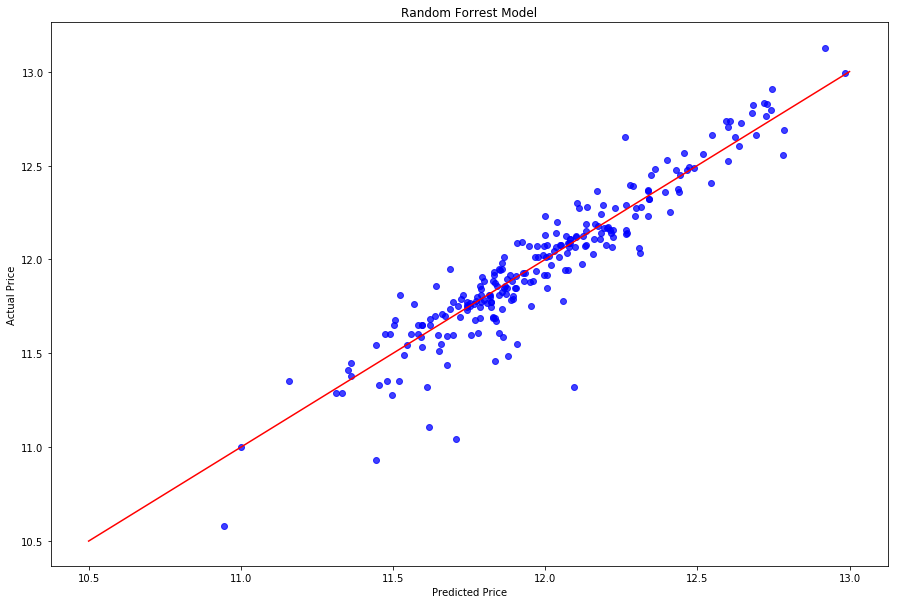

In [52]:
actual_values = y_test
plt.figure(figsize=(15,10))
plt.scatter(fr_preds, actual_values, alpha=.75, color='b') 
plt.plot([10.5,13],[10.5,13],"r")
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Random Forrest Model')
plt.show()

The random forrest model performs the worst of all the models tested so far. It could probably perform better after some hyperparameter tuning. But since our other models seem to perform much better, we will most likely use some of them in our final prediction.

## Support Vector Regressor <a name="subparagraph11"></a>

The Support Vector Regression (SVR) uses the same principles as the SVM for classification, with only a few minor differences. First of all, because output is a real number it becomes very difficult to predict the information at hand, which has infinite possibilities. In the case of regression, a margin of tolerance (epsilon) is set in approximation to the SVM which would have already requested from the problem. But besides this fact, there is also a more complicated reason, the algorithm is more complicated therefore to be taken in consideration. However, the main idea is always the same: to minimize error, individualizing the hyperplane which maximizes the margin, keeping in mind that part of the error is tolerated. 

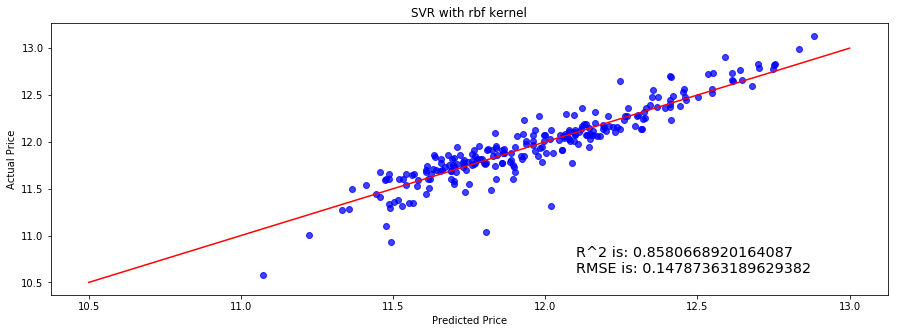

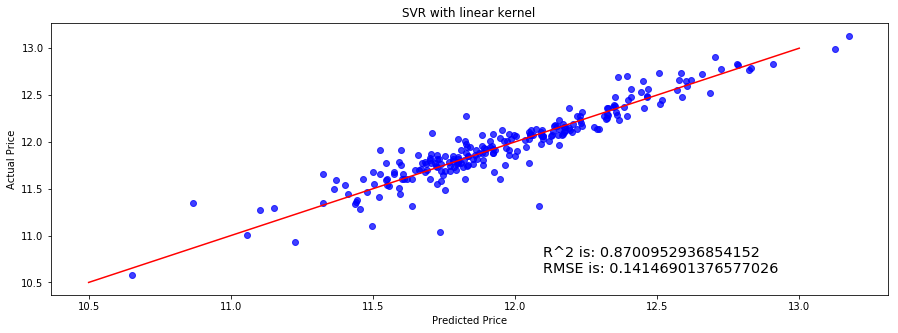

In [53]:
svr_rbf = SVR(kernel='rbf')
svr_lin = SVR(kernel='linear')
svr_rbf_model = svr_rbf.fit(X_train, y_train)
svr_lin_model = svr_lin.fit(X_train, y_train)
rbf_preds = svr_rbf_model.predict(X_test)
lin_preds = svr_lin_model.predict(X_test)
rbf_rmse = np.sqrt(mean_squared_error(y_test, rbf_preds))
lin_rmse = np.sqrt(mean_squared_error(y_test, lin_preds))

# plot SVR with rbf kernel
plt.figure(figsize=(15,5))
plt.scatter(rbf_preds, actual_values, alpha=.75,
            color='b') 
plt.plot([10.5,13],[10.5,13],"r")
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('SVR with rbf kernel')
overlay = 'R^2 is: {}\nRMSE is: {}'.format(
                svr_rbf_model.score(X_test, y_test),
                rbf_rmse)
plt.annotate(s=overlay,xy=(12.1,10.6),size='x-large')
plt.show()

# plot SVR with linear kernel
plt.figure(figsize=(15,5))
plt.scatter(lin_preds, actual_values, alpha=.75, color='b') 
plt.plot([10.5,13],[10.5,13],"r")
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('SVR with linear kernel')
overlay = 'R^2 is: {}\nRMSE is: {}'.format(
                svr_lin_model.score(X_test, y_test),
                lin_rmse)
plt.annotate(s=overlay,xy=(12.1,10.6),size='x-large')
plt.show()


In [54]:
scores = cross_val_score(svr_lin, X_test, y_test, cv=10)
print("Cross validation score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Cross validation score: 0.77 (+/- 0.21)


Lookin at our plots above a linear kernel looks like the best choise. The accuracy seems quite low, and we can see there are some large errors in the predicictions. It performs bad as a model on its own, but we will keep it as it may be usefull in our stacking regressor.

## Gradient boosting <a name="subparagraph12"></a>

The idea behind gradient boosting it to make several weak learners and combine them into a strong learniner. This can be done using the algorithm below

1. Fit a model to the data, $F_1(x) = y$
2. Fit a model to the residuals, $h_1(x) = y - F_1(x)$
3. Create a new model, $F_2(x)= F_1(x) + h_1(x)$

We will first use a regular gradient boost regressor without tuning its parameters before we tune its parameters using a grid seach

<img src="GradientBoosting.png">

<module 'matplotlib.pyplot' from 'C:\\Users\\Christian\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

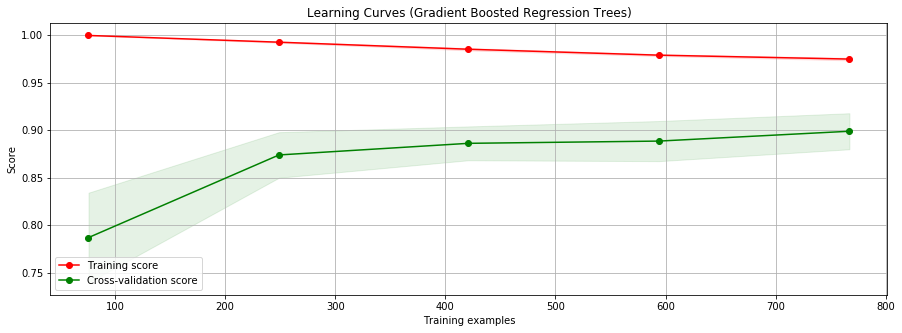

In [55]:
gb = GradientBoostingRegressor()
title = "Learning Curves (Gradient Boosted Regression Trees)"
plot_learning_curve(gb, title, X_train, y_train, cv=cv, n_jobs=4)

In [56]:
gradientBoostingModel = gb.fit(X_train, y_train)
print ("R^2 is:", gradientBoostingModel.score(X_test, y_test))

R^2 is: 0.876209344329278


In [57]:
predictions = gradientBoostingModel.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print ('RMSE is:', rmse)

RMSE is: 0.13809972533715012


In [58]:
scores = cross_val_score(gradientBoostingModel, X_test, y_test, cv=10)
print("Cross validation score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Cross validation score: 0.80 (+/- 0.16)


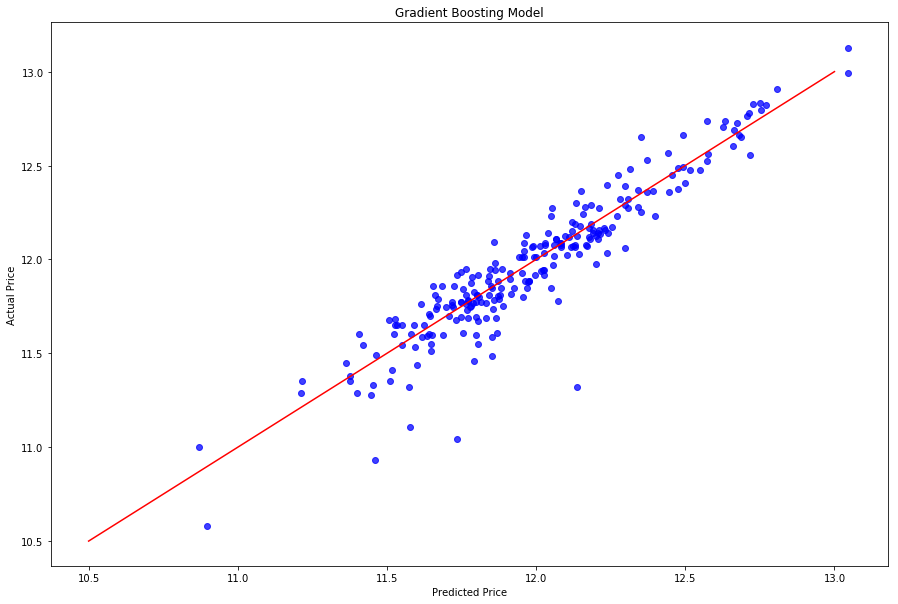

In [59]:
actual_values = y_test
plt.figure(figsize=(15,10))
plt.scatter(predictions, actual_values, alpha=.75,color='b') 
plt.plot([10.5,13],[10.5,13],"r")
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Gradient Boosting Model')
plt.show()

The gradient boost model are created by combining weak learners in a tree structure like a decition three. That makes it able to know the impact of each feature on the final result. Lets see which of our features are the most important ones.

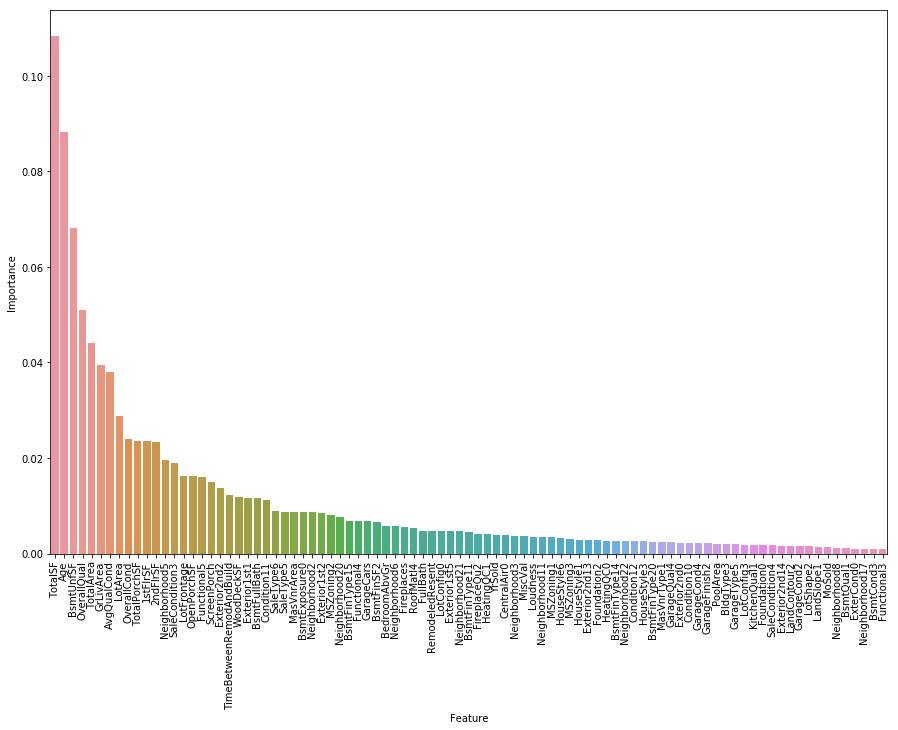

In [60]:
# find the importance of each feature in the gradient boosting model
importances = gb.feature_importances_

# sort features based on importance
featureImportanceDF = pd.DataFrame(data={"Feature":columns,"Importance":importances})\
    .sort_values(by="Importance",ascending=0).query("Importance > 0.001")
    
plt.figure(figsize=(15,10))
plt.xticks(rotation='90')
sns.barplot(x="Feature", y="Importance",data=featureImportanceDF)

### Improving Gradient Boosting

In [61]:
param_grid={'n_estimators':[100,500,1000,2000,3000],
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'max_depth':[4,6],
            'min_samples_leaf':[3,5,9,17], 
            'max_features':[1.0,0.3,0.1]
           }

# We will try to load a picled version of the estimator, so we dont need to run it anew each time
try:
    print("Loading from file..")
    best_est = pickle.load( open( "GradientBoostingEstimator_odd_optim.p", "rb" ) )
    None
except:
    print("Calculating parameters..")
    model_gb = GradientBoostingRegressor()
    best_est = hyperparameterTuning(model_gb,param_grid,cv)
    None

Loading from file..


In [62]:
#pickle.dump(best_est, open( "GradientBoostingBestEstimator.p", "wb" ) )

<module 'matplotlib.pyplot' from 'C:\\Users\\Christian\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

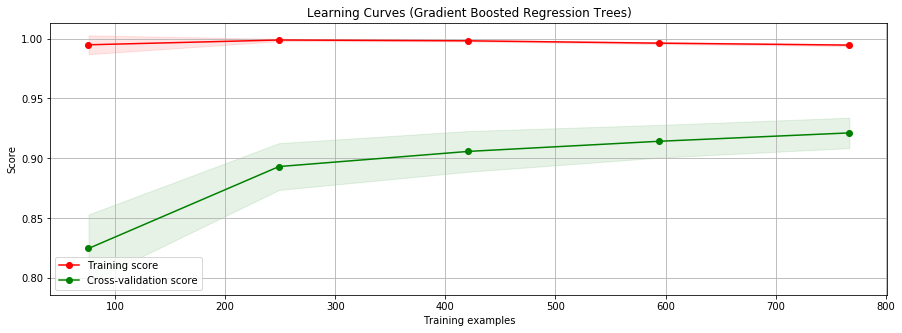

In [63]:
model_gb = GradientBoostingRegressor(n_estimators=best_est.n_estimators, max_depth=best_est.max_depth,
            learning_rate=best_est.learning_rate, min_samples_leaf=best_est.min_samples_leaf,
            max_features=best_est.max_features,loss="huber",random_state=5)

title = "Learning Curves (Gradient Boosted Regression Trees)"
plot_learning_curve(model_gb, title, X_train, y_train, cv=cv, n_jobs=4)

In [64]:
model_gb.fit(X_train, y_train)
gb_preds = model_gb.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, gb_preds))

print ("R^2 is:", model_gb.score(X_test, y_test))
print ('RMSE is:', rmse)

R^2 is: 0.8929849386480937
RMSE is: 0.12840186613188392


In [65]:
scores = cross_val_score(model_gb, X_test, y_test, cv=10)
print("Cross validation score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Cross validation score: 0.84 (+/- 0.18)


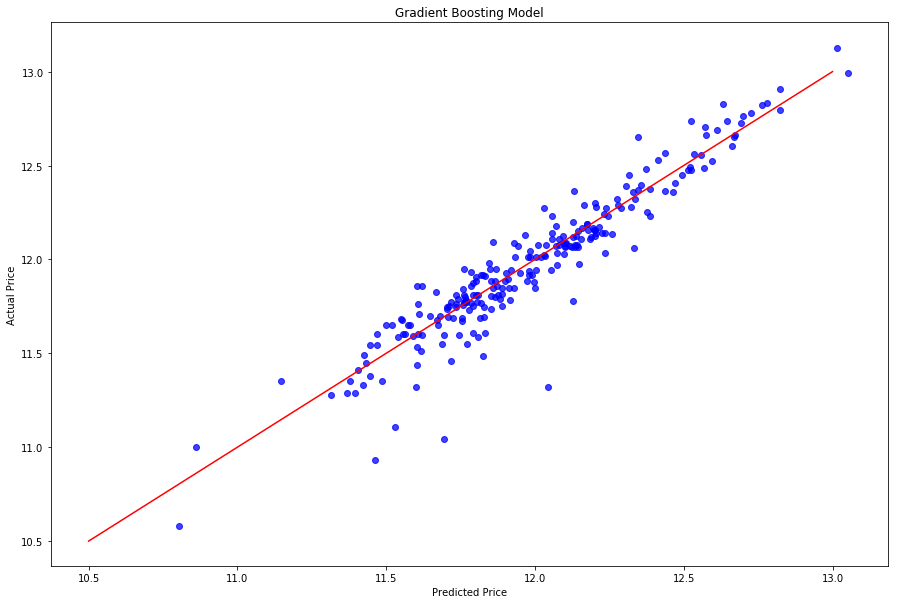

In [66]:
actual_values = y_test
plt.figure(figsize=(15,10))
plt.scatter(gb_preds, actual_values, alpha=.75,color='b') 
plt.plot([10.5,13],[10.5,13],"r")
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Gradient Boosting Model')
plt.show()

## Using XGBoost <a name="subparagraph13"></a>

In [67]:
# https://datascience.stackexchange.com/questions/16904/gbm-vs-xgboost-key-differences?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa
# https://stats.stackexchange.com/questions/307555/mathematical-differences-between-gbm-xgboost-lightgbm-catboost

XGBoost is a gradient boosting library, alternativly to sklear that we are using above. Both xgboost and gbm follows the principle of gradient boosting. There are however, the difference in modeling details. Specifically, xgboost used a more regularized model formalization to control over-fitting, which gives it better performance.

In [68]:
param_grid={'learning_rate': [0.05, 0.02, 0.01],
            'max_depth':[4,6,8],
            'gamma':[0.01,0.04,0.08,0.12], 
            'subsample':[0.5,0.75,1],
            'colsample_bytree':[0.5,0.75,1],
            'reg_alpha':[0.001,0.01,0.1],
            'reg_lambda':[0.001,0.01,0.1],
            'n_estimators':[2000,3000]
           }
try:
    best_est = pickle.load( open( "XGBoostBestEstimator_optim.p", "rb" ) )
    None
except:
    model_xgb = xgb.XGBRegressor()
    best_est = hyperparameterTuning(model_xgb,param_grid,cv)
    None

In [69]:
#pickle.dump(best_est, open( "XGBoostBestEstimator.p", "wb" ) )

<module 'matplotlib.pyplot' from 'C:\\Users\\Christian\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

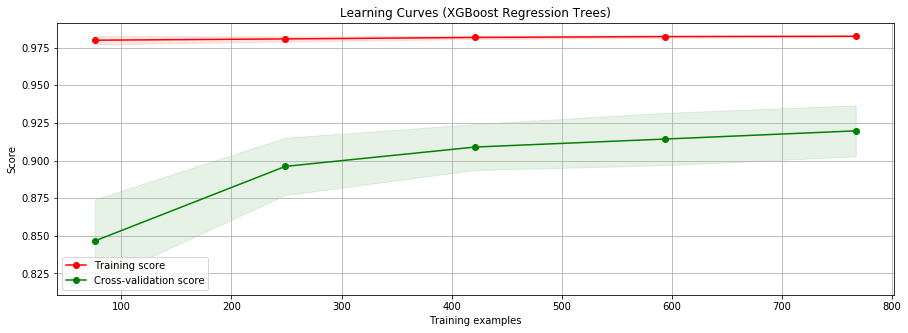

In [70]:
"""
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=6, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
"""
model_xgb = xgb.XGBRegressor(colsample_bytree=best_est.colsample_bytree, gamma=best_est.gamma, 
                             learning_rate=best_est.learning_rate, max_depth=best_est.max_depth, 
                             min_child_weight=best_est.min_child_weight, n_estimators=best_est.n_estimators,
                             reg_alpha=best_est.reg_alpha, reg_lambda=best_est.reg_lambda,
                             subsample=best_est.subsample, silent=1,
                             random_state =7, nthread = -1)


title = "Learning Curves (XGBoost Regression Trees)"
plot_learning_curve(model_xgb, title, X_train, y_train, cv=cv)

In [71]:
model_xgb.fit(X_train, y_train)
xgb_preds = model_xgb.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
print ("R^2 is:", model_xgb.score(X_test, y_test))
print ('RMSE is:', rmse)

R^2 is: 0.8901330763649827
RMSE is: 0.13010151841633866


In [72]:
scores = cross_val_score(model_xgb, X_test, y_test, cv=10)
print("Cross validation score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Cross validation score: 0.83 (+/- 0.17)


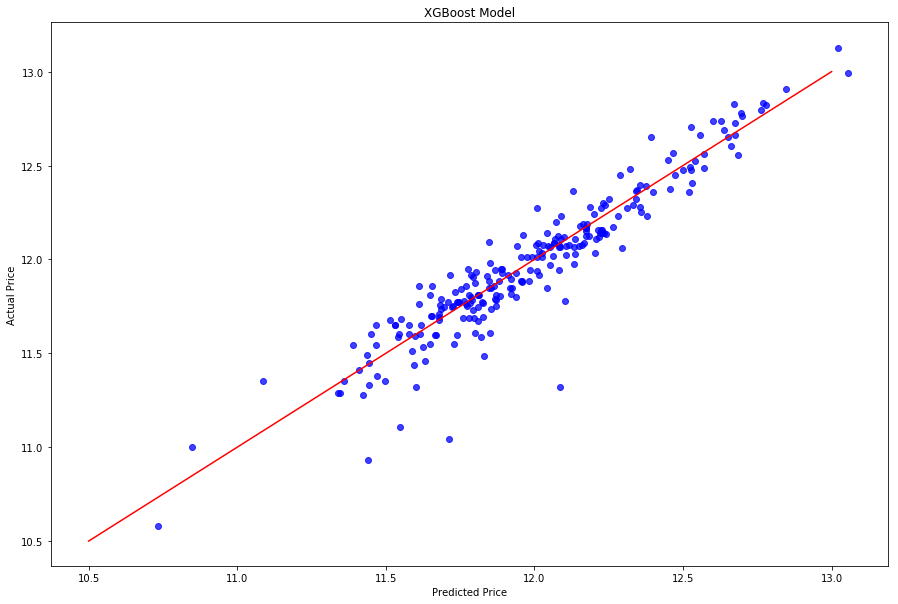

In [73]:
actual_values = y_test
plt.figure(figsize=(15,10))
plt.scatter(xgb_preds, actual_values, alpha=.75, color='b') 
plt.plot([10.5,13],[10.5,13],"r")

plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('XGBoost Model')
plt.show()

### Using LightGBM <a name="subparagraph14"></a>

In [74]:
# https://www.kaggle.com/nschneider/gbm-vs-xgboost-vs-lightgbm
# https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc

Light GBM grows tree vertically while other algorithm grows trees horizontally meaning that Light GBM grows tree leaf-wise while other algorithm grows level-wise. It will choose the leaf with max delta loss to grow. When growing the same leaf, Leaf-wise algorithm can reduce more loss than a level-wise algorithm.

<img src="LightGBM.png">

In [75]:
param_grid={'n_estimators':[100,500,1000,2000],
            'learning_rate': [0.1, 0.05, 0.02, 0.01],
            'max_depth':[4,6],
            'min_samples_leaf':[3,5,9,17], 
            'max_features':[1.0,0.3,0.1]
           }
"""
try:
    best_est = pickle.load( open( "LightGBMBestEstimator.p", "rb" ) )
except:
    model_lgb = lgb.LGBMRegressor()
    best_est = hyperparameterTuning(model_lgb,param_grid,cv)
    None
"""

'\ntry:\n    best_est = pickle.load( open( "LightGBMBestEstimator.p", "rb" ) )\nexcept:\n    model_lgb = lgb.LGBMRegressor()\n    best_est = hyperparameterTuning(model_lgb,param_grid,cv)\n    None\n'

In [76]:
#pickle.dump(best_est, open( "LightGBMBestEstimator.p", "wb" ) )

<module 'matplotlib.pyplot' from 'C:\\Users\\Christian\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

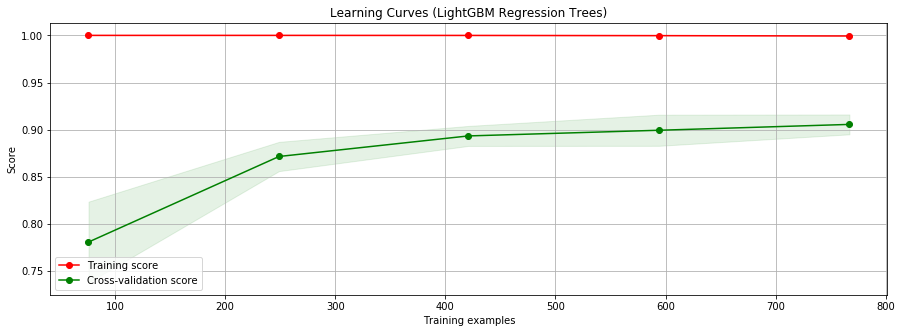

In [77]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.1, n_estimators=2200,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
title = "Learning Curves (LightGBM Regression Trees)"
plot_learning_curve(model_lgb, title, X_train, y_train, cv=cv)

In [78]:
model_lgb.fit(X_train, y_train)
lgb_preds = model_lgb.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, lgb_preds))
print ("R^2 is:", model_lgb.score(X_test, y_test))
print ('RMSE is:', rmse)

R^2 is: 0.8759198393845458
RMSE is: 0.13826111556948403


In [79]:
scores = cross_val_score(model_lgb, X_test, y_test, cv=10)
print("Cross validation score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Cross validation score: 0.80 (+/- 0.19)


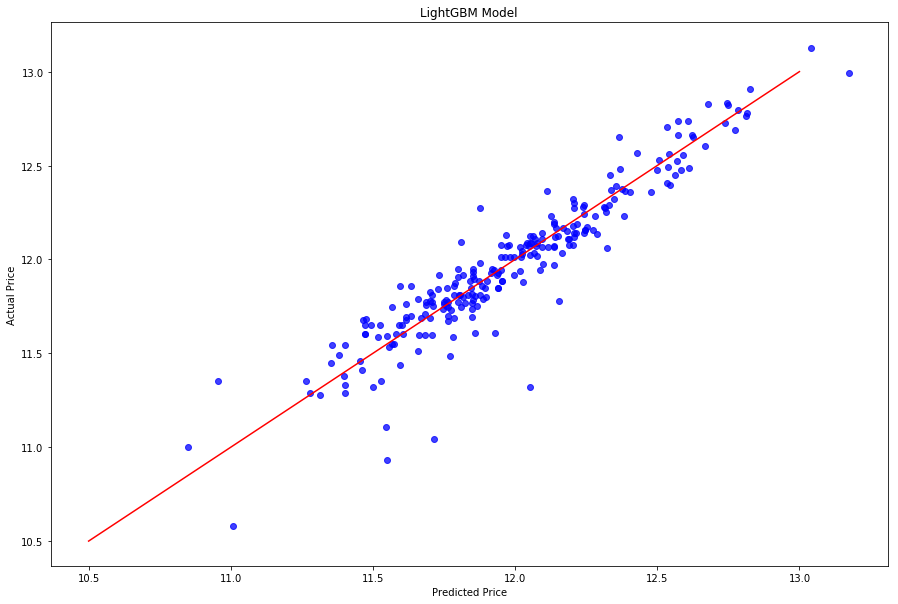

In [80]:
actual_values = y_test
plt.figure(figsize=(15,10))
plt.scatter(lgb_preds, actual_values, alpha=.75,color='b') 
plt.plot([10.5,13],[10.5,13],"r")

plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('LightGBM Model')
plt.show()

## Stacking Regressor <a name="subparagraph15"></a>

<img src="stackingregression_overview.png">

As the picture above describes we are going to use the predictions of several models as input for our Meta-Regressor. In this case we have choosen a LassoRegressor model as our Meta-Regressor. Stacking models like this have been proven to improve the overall accuracy of our predictions #Reference#. This is beacuse some models are able catch spesific aspects aboute our data that others may not. So by stacking models horizontaly we are able to weight some predictions more than others, and in this way increase our final predictions.

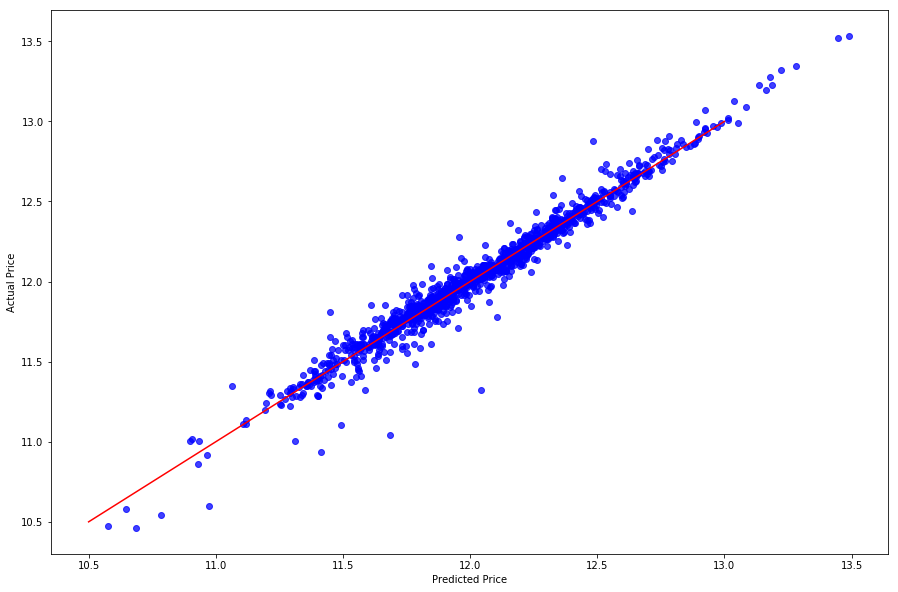

RMSE is: 0.074514824611559


In [81]:
ridge_model = rm.fit(X_train, y_train)
rm_preds = ridge_model.predict(X_test)

lgb_test_preds = model_lgb.predict(X)
xgb_test_preds = model_xgb.predict(X)
gb_test_preds = model_gb.predict(X)
rm_test_preds = ridge_model.predict(X)
br_test_preds = bayesian_model.predict(X)
fr_test_preds = randomForrestModel.predict(X)

all_preds = np.array([lgb_preds,rm_preds,xgb_preds,gb_preds,br_preds]).T
all_test_preds = np.array([lgb_test_preds,rm_test_preds,xgb_test_preds,gb_test_preds,br_test_preds]).T

lm = Lasso(alpha=0.001)
lasso_model = lm.fit(all_preds, y_test)
meta_preds = lasso_model.predict(all_test_preds)
plt.figure(figsize=(15,10))
plt.scatter(meta_preds, y, alpha=.75, color='b')
plt.plot([10.5,13],[10.5,13],"r")
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.show()

rmse = np.sqrt(mean_squared_error(y, meta_preds))
print ('RMSE is:', rmse)

We can see that the RMSE now is artificially low. The predictions we have done here are on our entire training dataset, so it cant directly be compared with the other models above. We still have some very large errors despite all our effort so far. Lets find out which point that are the worst predicted ones, and try to see why it is so.

In [82]:
earlyMetaPreds = meta_preds
earlyY = y

# Capturing large errors <a name="paragraph7"></a>

We will now look at our predictions vs the actual price, and sort all predictions based on how large the error in the prediction is. Then we are going to look at some features that we know are higly correlated with the SalePrice, and see if it is something in the features that we may have missed.

In [83]:
errorDF = pd.DataFrame(data=np.exp(y_test))
errorDF["Prediction"] = np.exp(lgb_preds)
errorDF["Diff"] = abs(errorDF.Prediction - errorDF.SalePrice)
errorDF = errorDF.sort_values(by="Diff",ascending=0)
#res = errorDF.query("SalePrice < 11 & Prediction < 11.5")
errorDF.head(10)

,SalePrice,Prediction,Diff
Id,,,
633,82500.0,171545.449209,89045.449209
59,438780.0,525754.746342,86974.746342
219,311500.0,234626.687460,76873.312540
329,214500.0,144017.814333,70482.185667
463,62383.0,122171.157050,59788.157050
715,130500.0,189998.109262,59498.109262
57,172500.0,224529.367366,52029.367366
560,234000.0,182268.403197,51731.596803
679,372500.0,321109.483911,51390.516089


In [112]:
ids = errorDF.head(10).index.values
worstPredictions = houseDataDF[houseDataDF.index.isin(ids)]
columns = np.concatenate((highestCorrFeatures,["Neighborhood","YrSold"]))
worstPredictions[columns]

,OverallQual,GrLivArea,TotalBsmtSF,GarageCars,GarageArea,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,Neighborhood,YrSold
Id,,,,,,,,,,,,
57,8,1739,970,2,480,983,2,7,1999,2000,Somerst,2009
59,10,2945,1410,3,641,1426,3,10,2006,2006,StoneBr,2006
219,7,1954,798,2,431,1137,1,8,1939,2006,Crawfor,2008
329,6,2134,844,2,441,1445,2,10,1916,1994,BrkSide,2009
463,5,864,864,1,360,864,1,5,1965,1965,Sawyer,2009
560,7,1557,1374,2,420,1557,2,7,2003,2004,Blmngtn,2006
633,7,1411,1386,2,544,1411,2,6,1977,1977,NWAmes,2009
679,8,2046,2046,3,834,2046,2,7,2008,2008,StoneBr,2009
715,6,1479,725,2,475,725,2,6,1976,2005,Sawyer,2010


When we look at the large errors above we can se that several of them are sold in late 2007 and 2008. This period contains a financial crisis, that had a huge effect on the world economy. It wass bad times where people lost their savings, lost their jobs and many peoples futures looked dark. Many houses may have forced sold, due to bankruptcies at a much lower rate than their real value. This effekts our predictions quite much, as late 2007 and 2008 can be seen as very different market scenario than rest of the years. So to help with this we are going to make to different models. One to predict houses sold during the crisis, and one for the rest.

# Multiple models <a name="paragraph8"></a>

House prices not only effected by the condition and size of the house, but also how the economy is doing, the house price index, the job security, and many others. We will add tree new features to our datasets, to add the contidtion of the market when the house is sold to our predictions. The tree features will be explaned below.

- Us bonds. The difference beweent the 10 year UsBonds and the 2 year UsBonds is a good indicator to see how the economy in America is doing.
- Vacancy level. High vacancy means high unsertainty in the job market, which in turn effects house prices.
- House price index. The house price index gives a general measure how the property market is in a whole.

In [85]:
usBondsDF = pd.read_csv(base + "T10Y2Y.csv")
usBondsDF.T10Y2Y = usBondsDF.T10Y2Y.apply(lambda x :0.0 if x == "." else float(x)).apply(lambda x : x * 100)
usBondsDF.DATE = usBondsDF.DATE.apply(lambda x : x[:-3])
idColl = usBondsDF.DATE
usBondsDF.index = idColl
usBondsDF = usBondsDF.drop(["DATE"],axis=1)

vacencyDF = pd.read_csv(base + "ILRVAC.csv")
#vacencyDF.ILRVAC = vacencyDF.ILRVAC.apply(lambda x : x * 10)
vacencyDF.DATE = vacencyDF.DATE.apply(lambda x : x[:4])
idColl = vacencyDF.DATE
vacencyDF.index = idColl
vacencyDF = vacencyDF.drop(["DATE"],axis=1)

housingPrisesIndexDF = pd.read_csv(base + "CSUSHPINSA.csv")
housingPrisesIndexDF.CSUSHPINSA_diff = housingPrisesIndexDF.CSUSHPINSA_diff.apply(lambda x :0.0 if x == "NaN" else float(x)).apply(lambda x : x + 3.525000)
housingPrisesIndexDF.DATE = housingPrisesIndexDF.DATE.apply(lambda x : x[:-3])
idColl = housingPrisesIndexDF.DATE
housingPrisesIndexDF.index = idColl
housingPrisesIndexDF = housingPrisesIndexDF.drop(["DATE"],axis=1)

In [86]:
def findBondsValueByDate(year,month):
    if month < 10:
        month = "0"+str(month)
    date = str(year)+"-"+str(month)
    res = usBondsDF.loc[date][0]
    return res

def findVacencyByYear(year):
    res = vacencyDF.loc[str(year)][0]
    return res

def findHousePriceIndexByDate(year,month):
    if month < 10:
        month = "0"+str(month)
    date = str(year)+"-"+str(month)
    res = housingPrisesIndexDF.loc[date]["CSUSHPINSA_diff"]    
    return res

houseDataDF["USBonds"] = [findBondsValueByDate(x,y) for x,y in zip(houseDataDF.YrSold,houseDataDF.MoSold)]
testDF["USBonds"] = [findBondsValueByDate(x,y) for x,y in zip(testDF.YrSold,testDF.MoSold)]

houseDataDF["Vacency"] = [findVacencyByYear(x) for x in houseDataDF.YrSold]
testDF["Vacency"] = [findVacencyByYear(x) for x in testDF.YrSold]

houseDataDF["HousePriceIndex"] = [findHousePriceIndexByDate(x,y) for x,y in zip(houseDataDF.YrSold,houseDataDF.MoSold)]
testDF["HousePriceIndex"] = [findHousePriceIndexByDate(x,y) for x,y in zip(testDF.YrSold,testDF.MoSold)]

Below are some common methods for both of our methods.

In [87]:
def queryAndPrepareData(query):
    relevantTrainDataDF = houseDataDF.query(query)

    relevantTrainDataLenght = len(relevantTrainDataDF.values)

    relevantTrainDataIds = relevantTrainDataDF.index.values

    relevantTestDataDF = testDF.query(query)

    relevantTestDataIds = relevantTestDataDF.index.values

    y = np.log(relevantTrainDataDF.SalePrice)

    relevantTrainDataDF = relevantTrainDataDF.drop(["SalePrice"],axis=1)

    totalRelevantDataDF = pd.concat([relevantTrainDataDF,relevantTestDataDF])

    totalRelevantDataDF = hotEncodeCategoricalFeatures(totalRelevantDataDF)

    totalRelevantDataDF = makeNewFeatures(totalRelevantDataDF)

    totalRelevantDataDF = fixSkew(totalRelevantDataDF)
    
    data = totalRelevantDataDF.select_dtypes(include=[np.number]).interpolate().dropna()
    drop_cols = ["YearBuilt",'YearRemodAdd', 'GarageYrBlt', 'GarageArea', 'TotalBsmtSF', 'BsmtFinSF1']
    data = data.drop(drop_cols,axis=1)
    columns = data.columns.values
    trainData = pd.DataFrame(data=data.values[:relevantTrainDataLenght],columns=columns)
    testData = pd.DataFrame(data=data.values[relevantTrainDataLenght:],columns=columns)
    
    return trainData,testData,y,relevantTestDataIds

def plotModelResult(model,X,y):
    preds = model.predict(X)
    score = model.score(X,y)
    plt.figure(figsize=(15,10))
    plt.scatter(preds, y, alpha=.75, color='b')
    plt.plot([10.5,13.5],[10.5,13.5],"r")
    plt.xlabel('Predicted Price')
    plt.ylabel('Actual Price')
    rmse = np.sqrt(mean_squared_error(np.exp(y), np.exp(preds)))
    overlay = 'R^2 is: {}\nMSE is: {}'.format(
                score,
                rmse)
    plt.annotate(s=overlay,xy=(12.1,10.6),size='x-large')
    plt.show()
    return preds

def predict(models,data):
    return np.array([model.predict(data) for model in models]).T

def trainModels(models,X_train,y_train,X_test,X):
    all_preds = []
    all_test_preds = []
    for model in models:
        model.fit(X_train, y_train)
        all_preds.append(model.predict(X_test))
        all_test_preds.append(model.predict(X))
        
    return np.array(all_preds).T,np.array(all_test_preds).T

## Financial crisis model <a name="subparagraph16"></a>

Our financial crisis model will contain sales from august 2007 and the entire 2008. We expect that expecialy high-end houses will benefit from this approach as we have seen they are sold at a much lower price in this period.

In [88]:
trainData,testData,y,relevantTestDataIds = queryAndPrepareData("YrSold == 2008 | (YrSold == 2007 & MoSold >= 8)")

In [89]:
X = trainData
training_features = X.columns.values

X_train, X_test, y_train, y_test = train_test_split(
                                    X, y, random_state=42, test_size=.2)

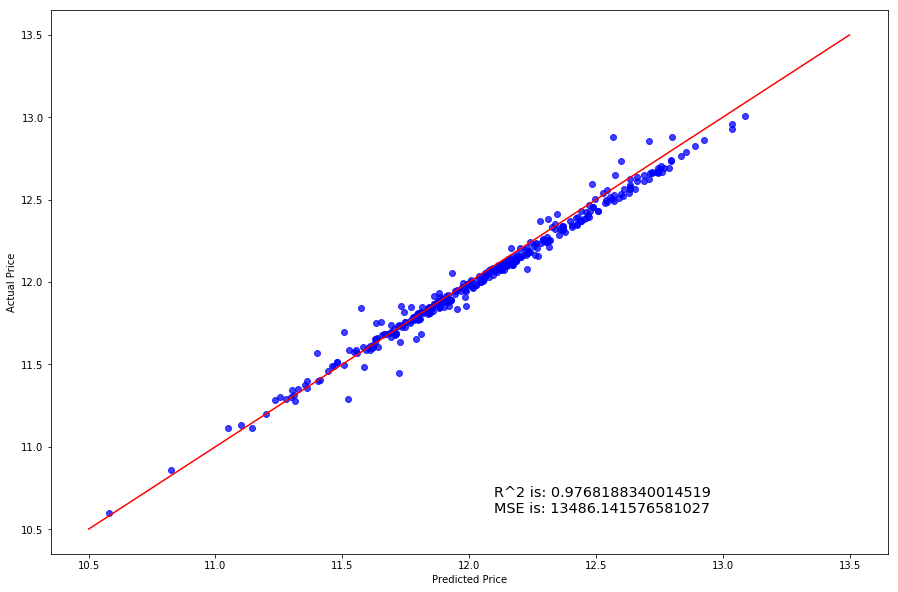

In [90]:
models = [model_gb,model_lgb,model_xgb,svr_lin_model]
#models = [rm,model_gb,model_lgb,model_xgb,bayesian_model,randomForrestModel,svr_lin_model]

all_preds , all_test_preds = trainModels(models,X_train,y_train,X_test,X)

meta_model = lm.fit(all_preds, y_test)

crisisPreds = plotModelResult(meta_model,all_test_preds,y)
crisisY = y

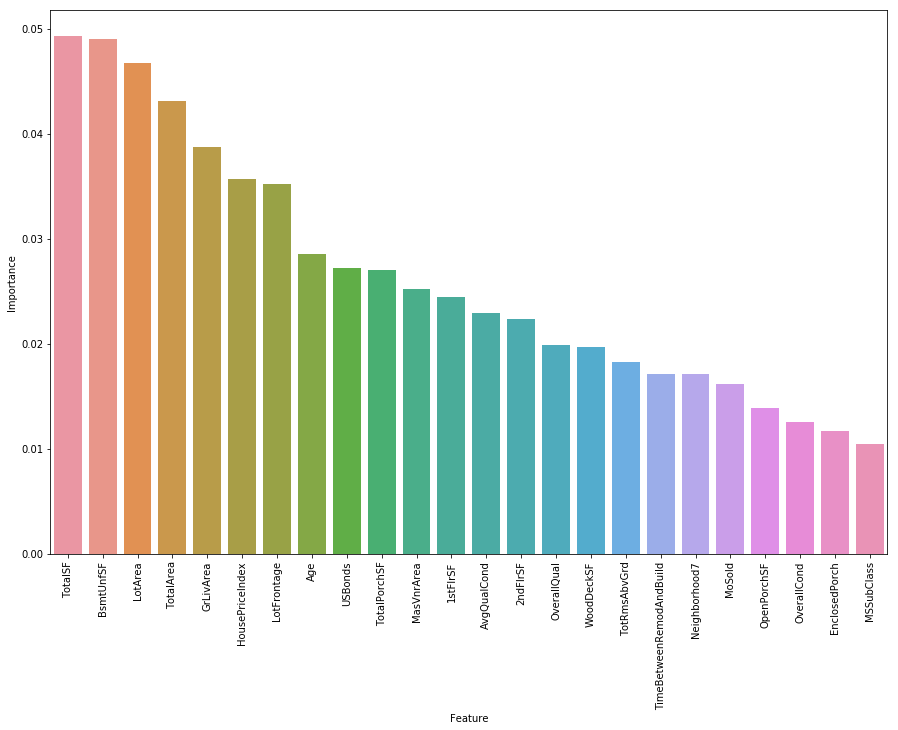

In [91]:
importances = model_gb.feature_importances_
columns = X_test.columns.values

featureImportanceDF = pd.DataFrame(data={"Feature":columns,"Importance":importances})\
    .sort_values(by="Importance",ascending=0).query("Importance > 0.01")
    
plt.figure(figsize=(15,10))
plt.xticks(rotation='90')
sns.barplot(x="Feature", y="Importance",data=featureImportanceDF)

In [92]:
all_model_preds = predict(models,testData)

final_predictions = np.exp(lasso_model.predict(all_model_preds))

submission1 = pd.DataFrame()
submission1['Id'] = relevantTestDataIds
submission1['SalePrice'] = final_predictions
submission1.head(20)

,Id,SalePrice
0,1209,141409.410193
1,1222,134861.641019
2,1225,220417.135452
3,1227,191743.158991
4,1228,142341.518938
5,1229,386973.620562
6,1230,153437.306206
7,1231,183528.922555
8,1235,131007.384474
9,1240,225186.222413


## Non crisis model <a name="subparagraph17"></a>

Our non crisis model will contain sales from 2006, 2009, 2010 and until july 2007.

In [93]:
trainData,testData,y,relevantTestDataIds = queryAndPrepareData("YrSold == 2006 | (YrSold == 2007 & MoSold < 8) | YrSold == 2009 | YrSold == 2010")

In [94]:
X = trainData
training_features = X.columns.values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.2)

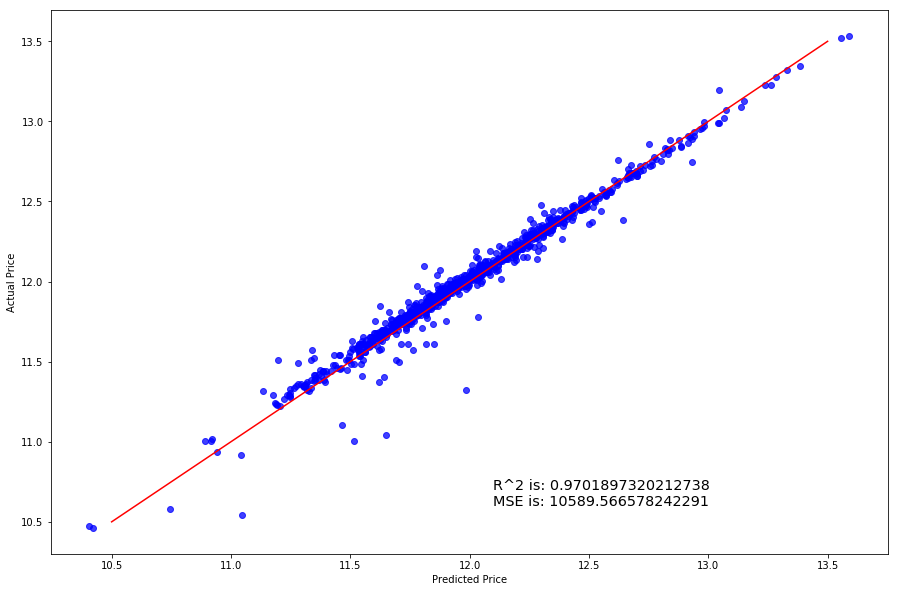

In [95]:
models = [model_gb,model_lgb,model_xgb,svr_lin_model]

all_preds , all_test_preds = trainModels(models,X_train,y_train,X_test,X)

meta_model = lm.fit(all_preds, y_test)

nonCrisisPreds = plotModelResult(meta_model,all_test_preds,y)
nonCrisisY = y

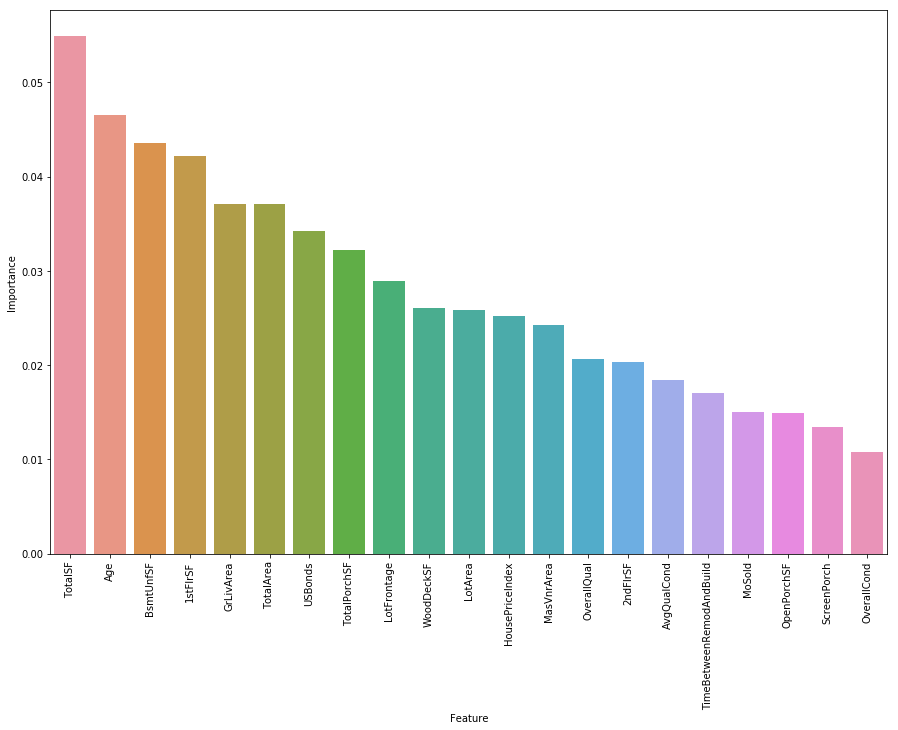

In [96]:
importances = model_gb.feature_importances_
columns = X_test.columns.values

featureImportanceDF = pd.DataFrame(data={"Feature":columns,"Importance":importances})\
    .sort_values(by="Importance",ascending=0).query("Importance > 0.01")
    
plt.figure(figsize=(15,10))
plt.xticks(rotation='90')
sns.barplot(x="Feature", y="Importance",data=featureImportanceDF)

In [97]:
all_model_preds = predict(models,testData)

final_predictions = np.exp(meta_model.predict(all_model_preds))

submission2 = pd.DataFrame()
submission2['Id'] = relevantTestDataIds
submission2['SalePrice'] = final_predictions
submission2.head(20)

,Id,SalePrice
0,1201,102740.872292
1,1202,189739.014151
2,1203,120661.746530
3,1204,206232.660561
4,1205,146999.815412
5,1206,302800.587037
6,1207,109189.013940
7,1208,202412.359856
8,1210,286027.033570
9,1211,191338.675208


## Merging the models <a name="subparagraph18"></a>

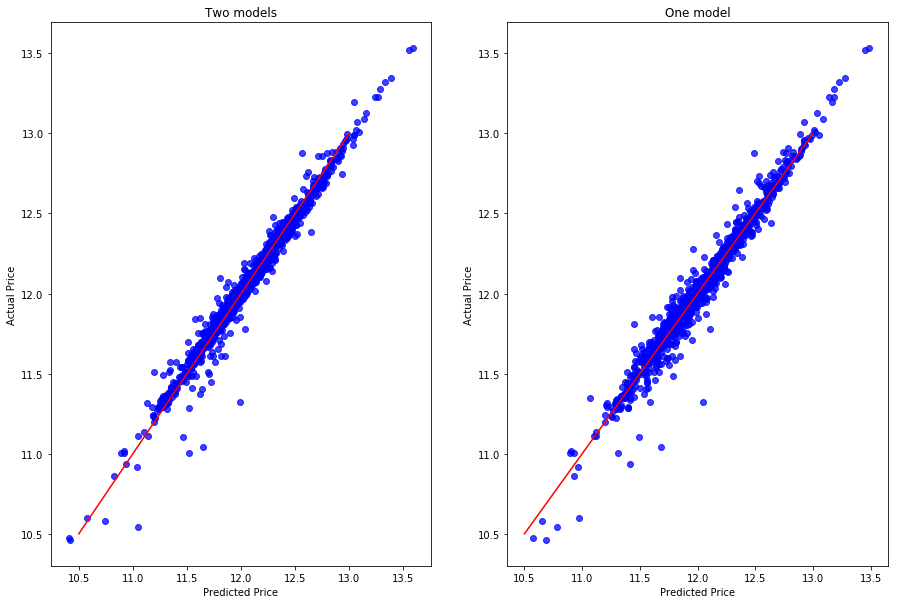

RMSE one model: 0.074514824611559
RMSE two models: 0.06756402020345387


In [102]:
plt.figure(figsize=(15,10))

plt.subplot(121)
yAll = np.concatenate((crisisY.values,nonCrisisY.values))
allPreds = np.concatenate((crisisPreds,nonCrisisPreds))
plt.scatter(allPreds, yAll, alpha=.75, color='b')
plt.title("Two models")
plt.plot([10.5,13],[10.5,13],"r")
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')

plt.subplot(122)
plt.scatter(earlyMetaPreds, earlyY, alpha=.75, color='b')
plt.plot([10.5,13],[10.5,13],"r")
plt.xlabel('Predicted Price')
plt.title("One model")
plt.ylabel('Actual Price')
plt.show()

rmseTwo = np.sqrt(mean_squared_error(yAll, allPreds))
rmseOne = np.sqrt(mean_squared_error(earlyMetaPreds, earlyY))

print("RMSE one model:",rmseOne)
print("RMSE two models:",rmseTwo)

We can see by the rmse values above that splitting our original model into two have had a significant effenct. We will use this approach in our submission.

# Evaluate models

In [ ]:
"""
bestModelCombination = None
lowest_value = None
queries = ["YrSold == 2008 | (YrSold == 2007 & MoSold >= 8)","YrSold == 2006 | (YrSold == 2007 & MoSold < 8) | YrSold == 2009 | YrSold == 2010"]
models = [ridge_model,model_gb,model_lgb,model_xgb,bayesian_model,svr_lin_model]
for L in range(4, len(models)+1):
    for model_subset in itertools.combinations(models, L):
        submissions = []
        for query in queries:
            trainData,testData,y,testIds = queryAndPrepareData(query)
        
            X = trainData
            training_features = X.columns.values

            X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.2)
            
            all_preds , all_test_preds = trainModels(model_subset,X_train,y_train,X_test,X)

            meta_model = lm.fit(all_preds, y_test)

            all_model_preds = predict(model_subset,testData)

            final_predictions = np.exp(meta_model.predict(all_model_preds))
            
            submission = pd.DataFrame()
            submission['Id'] = testIds
            submission['SalePrice'] = final_predictions
            submissions.append(submission)
            
        allSubmission = pd.concat(submissions).sort_values("Id")
        rmse = np.sqrt(mean_squared_error(ansDF["SalePrice"],allSubmission["SalePrice"]))
        print(rmse)
        
        if  lowest_value == None or rmse < lowest_value:
            bestModelCombination = model_subset
            lowest_value = rmse

print(bestModelCombination)
"""

# Submission <a name="paragraph9"></a>

In [103]:
allSubmission = pd.concat([submission1,submission2]).sort_values("Id")
allSubmission.head(20)

,Id,SalePrice
0,1201,102740.872292
1,1202,189739.014151
2,1203,120661.746530
3,1204,206232.660561
4,1205,146999.815412
5,1206,302800.587037
6,1207,109189.013940
7,1208,202412.359856
0,1209,141409.410193
8,1210,286027.033570


In [104]:
allSubmission.to_csv('submission3.csv', index=False)

In [105]:
testDataDF = pd.read_csv(base + "train2.csv")
ansDF = pd.read_csv(base + "train2.csv")
idColl = ansDF.Id
ansDF = ansDF.drop(["Id"],axis=1)
ansDF.index = idColl
ansDF = pd.DataFrame(ansDF.SalePrice[1200:])
ansDF["Predicted"] = allSubmission.SalePrice.values
ansDF.head(20)

,SalePrice,Predicted
Id,,
1201,116050,102740.872292
1202,197900,189739.014151
1203,117000,120661.746530
1204,213000,206232.660561
1205,153500,146999.815412
1206,271900,302800.587037
1207,107000,109189.013940
1208,200000,202412.359856
1209,140000,141409.410193


In [106]:
ansDF["Diff"] = abs(ansDF["SalePrice"] - ansDF["Predicted"])
sortedAnsDF = ansDF.sort_values(by="Diff",ascending=False)
sortedAnsDF.head(20)

,SalePrice,Predicted,Diff
Id,,,
1299,160000,299867.628302,139867.628302
1325,147000,285302.943895,138302.943895
1360,315000,400962.612063,85962.612063
1212,164000,247975.341744,83975.341744
1424,274970,200833.147980,74136.852020
1454,84500,140118.853982,55618.853982
1448,240000,288767.240424,48767.240424
1387,250000,298524.205314,48524.205314
1244,465000,417740.022396,47259.977604


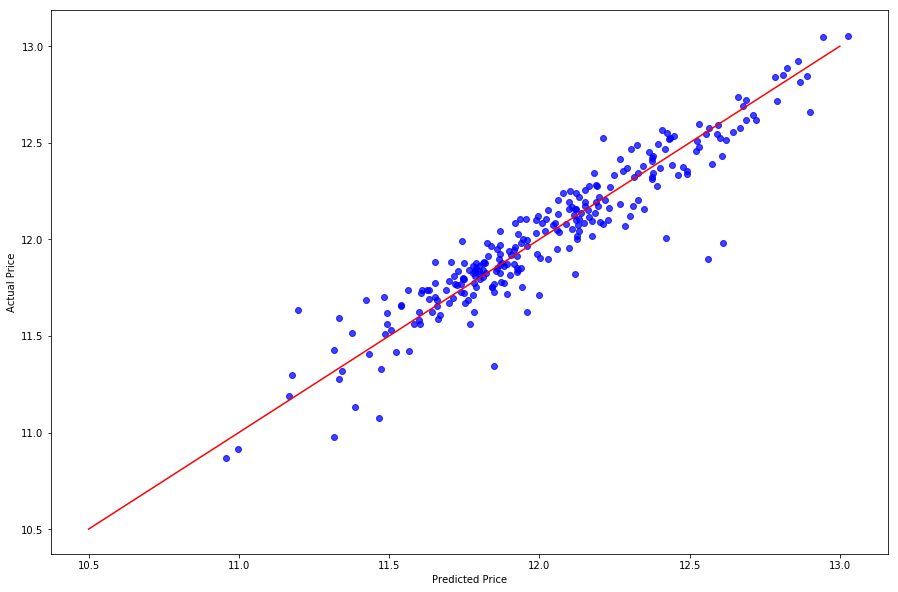

In [107]:
plt.figure(figsize=(15,10))
plt.scatter(np.log(ansDF.Predicted.values),np.log(ansDF.SalePrice.values), alpha=.75, color='b')
plt.plot([10.5,13],[10.5,13],"r")
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.show()

In [111]:
print("Root mean squared error:")
print(np.sqrt(mean_squared_error(np.log(ansDF["SalePrice"]),np.log(ansDF["Predicted"]))))

Root mean squared error:
0.13116100002230544


In [109]:
worstPredictions = testDataDF.query("Id == 1299 | Id == 1325 | Id == 1244 | Id == 1374 | Id == 1311")
columns = np.concatenate((highestCorrFeatures,["Neighborhood","YrSold","MoSold"]))
worstPredictions[columns]

,OverallQual,GrLivArea,TotalBsmtSF,GarageCars,GarageArea,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,Neighborhood,YrSold,MoSold
1243,10,2076,2076,3,850,2076,2,7,2006,2006,NridgHt,2006,9
1298,10,5642,6110,2,1418,4692,2,12,2008,2008,Edwards,2008,1
1310,7,1902,1902,2,567,1902,2,7,1959,2002,Crawfor,2010,5
1324,8,1795,1795,3,895,1795,2,7,2006,2007,Somerst,2007,2
1373,10,2633,2633,3,804,2633,2,8,2001,2002,NoRidge,2007,3


# References <a name="paragraph10"></a>

[1] U.S. Bureau of the Census, Housing Inventory Estimate: Vacant Housing Units for Sale for the United States [ESALEUSQ176N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/ESALEUSQ176N, May 15, 2018.

[2] U.S. Bureau of Labor Statistics, Consumer Price Index for All Urban Consumers: All Items [CPIAUCSL], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/CPIAUCSL, May 15, 2018.

[3] S&P Dow Jones Indices LLC, S&P/Case-Shiller U.S. National Home Price Index [CSUSHPINSA], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/CSUSHPINSA, May 14, 2018.